# NMME rElAtIvE Niño 3.4

In [1]:
import numpy as np
import xarray as xr

import pandas as pd

from matplotlib import pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

from datetime import datetime
months =[datetime(2019, imon, 1) for imon in np.arange(1, 12 + 1)]
month_str = [date_obj.strftime('%b') for date_obj in months]
m_str = [w[0] for w in month_str];

# Get color order
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

In [2]:
nmme_url = 'https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/'
real_n34_url = 'Y/-5/5/RANGEEDGES/X/190/240/RANGEEDGES%5BX/Y%5Daverage/'
n34_url = 'dup/Y/-5/5/RANGEEDGES/X/190/240/RANGEEDGES%5BX/Y%5Daverage/'\
          'exch/Y/-20/20/RANGEEDGES%5BX/Y%5Daverage/sub/'

In [3]:
model_list = ['CanCM4i', 'COLA-RSMAS-CCSM4', 'GEM-NEMO', 'GFDL-SPEAR', 'NASA-GEOSS2S', 'NCEP-CFSv2']

## Functions

In [4]:
# For the IRI DL 'months since' unit
def decode_cf(ds, time_var):
    if ds[time_var].attrs['calendar'] == '360':
        ds[time_var].attrs['calendar'] = '360_day'
    ds = xr.decode_cf(ds, decode_times=True)
    return ds

In [5]:
# correlation as function of start month
# need to compute the means over values where both are not missing
def ac_by_start(x, y):
    ok = ~np.isnan(x) & ~np.isnan(y)
    xa = x.where(ok).groupby('S.month') - x.where(ok).groupby('S.month').mean('S') 
    ya = y.where(ok).groupby('S.month') - y.where(ok).groupby('S.month').mean('S') 
    c = (xa*ya).groupby('S.month').mean('S')/xa.groupby('S.month').std('S')/ya.groupby('S.month').std('S')
    c.attrs['long_name'] = 'correlation'
    c.month.attrs['long_name'] = 'start month'
    # c = xr.corr(x.groupby('S.month'), y.groupby('S.month'), dim='S')
    return c

In [6]:
# MSE skill score as a function of start month
def msess_by_start(f, o):
    # assumes:
    # 1. f and o are anomalies (the mean is not removed here)
    # 2. the reference forecast is zero anomaly
    # Note: use mean instead of sum to get the desired nan behavior (nan if all values missing. e.g., models with shorter forecasts)
    msess = 1.0 - ((f - o)**2).groupby('S.month').mean('S')/(o**2).groupby('S.month').mean('S')
    msess.attrs['long_name'] = 'MSESS'
    msess.month.attrs['long_name'] = 'start month'
    return msess

# Read data from IRI Data Library

Be careful with IRI DL units `months since 1960`

## Observations (ERSSTv5)

In [7]:
# first read n34 for the climatological period that will be used to match the variance
# Construct the url pointing to the data
dl_loc = 'SOURCES/.NOAA/.NCDC/.ERSST/.version5/.sst/'
time_str = 'T/(Jan%201980)/last/RANGE/'
obs_url = 'https://iridl.ldeo.columbia.edu/' + dl_loc + time_str + n34_url + 'zlev/removeGRID/' + 'dods'

scaling_ds = xr.open_dataset(obs_url, decode_times=False)
# BECAUSE the forecasts go beyond the obs pad with 14 nan
extra_T = np.arange(scaling_ds.T[0], scaling_ds.T[-1] + 14)
scaling_ds_padded = scaling_ds.reindex({'T': extra_T})
# scaling is the variable that will be used lated
scaling = scaling_ds_padded.sst

2023-09-16 00:00:00


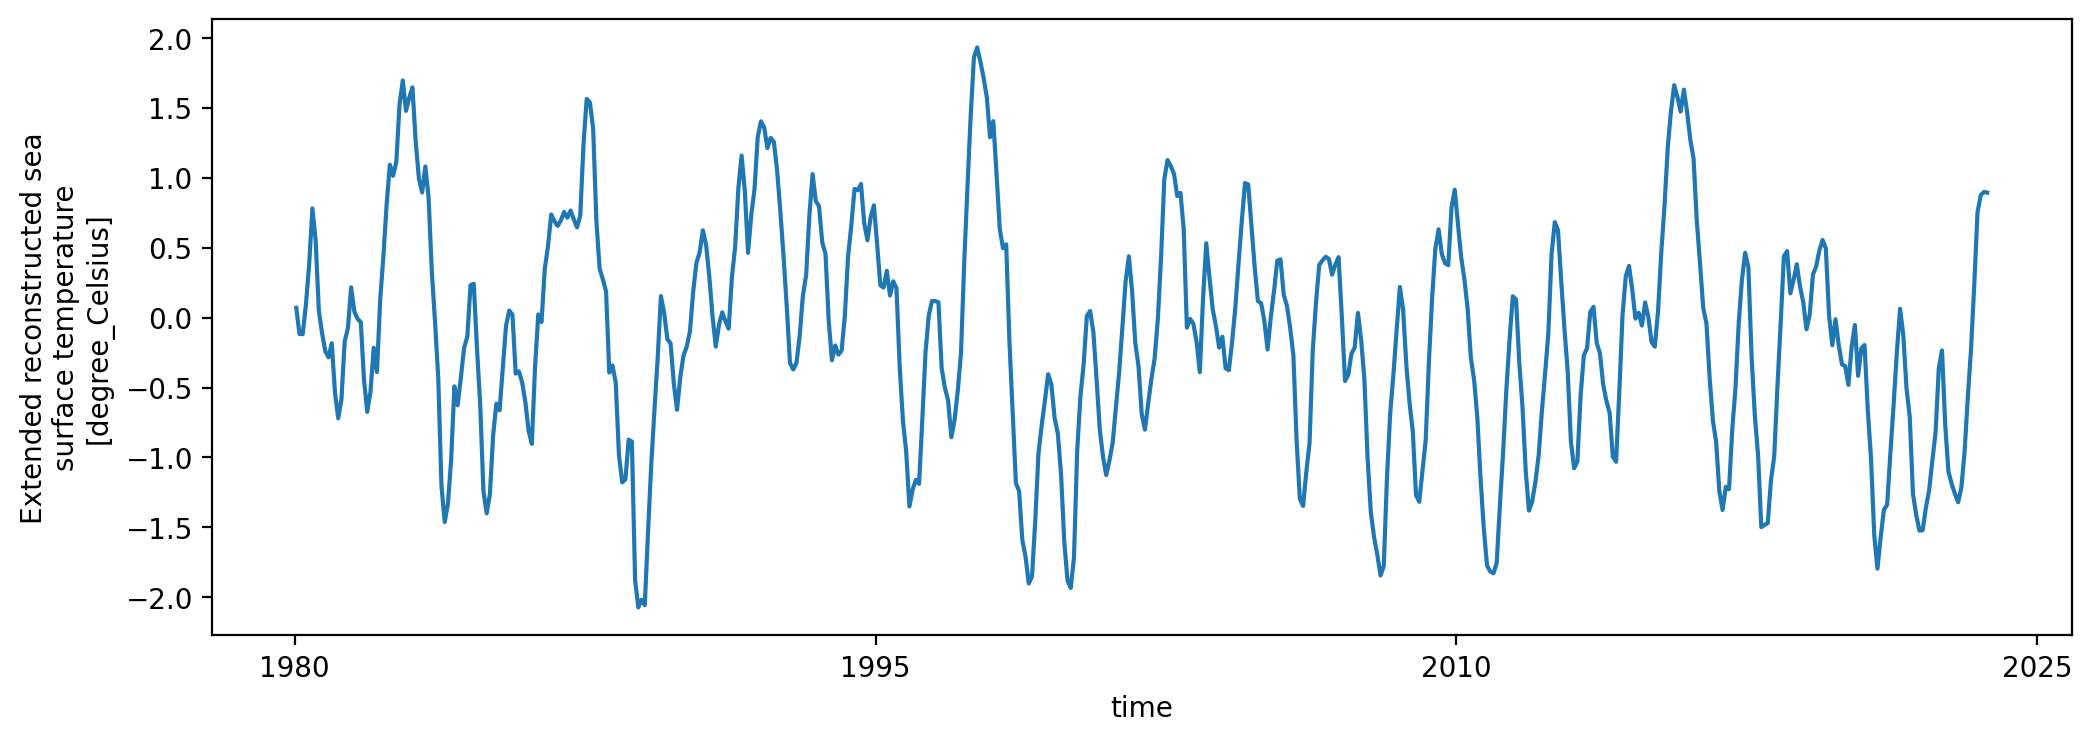

In [8]:
#Observations do not have to match the forecasts

# Construct the url pointing to the data
dl_loc = 'SOURCES/.NOAA/.NCDC/.ERSST/.version5/.sst/'
time_str = 'T/(Jan%201980)/last/RANGE/'
obs_url = 'https://iridl.ldeo.columbia.edu/' + dl_loc + time_str + n34_url + 'zlev/removeGRID/' + 'dods'

obs_ds = xr.open_dataset(obs_url, decode_times=False)

# BECAUSE the forecasts go beyond the obs pad with 14 nan
extra_T = np.arange(obs_ds.T[0], obs_ds.T[-1] + 14)
obs_ds_padded = obs_ds.reindex({'T': extra_T})
# obs is the variable that will be used lated
obs = obs_ds_padded.sst
#
obs_ds_decoded = decode_cf(obs_ds, 'T')
print(obs_ds_decoded.T[-1].values)
obs_ds_decoded.sst.plot(figsize=(12, 4));

In [9]:
from platform import python_version
print(python_version())

3.10.11


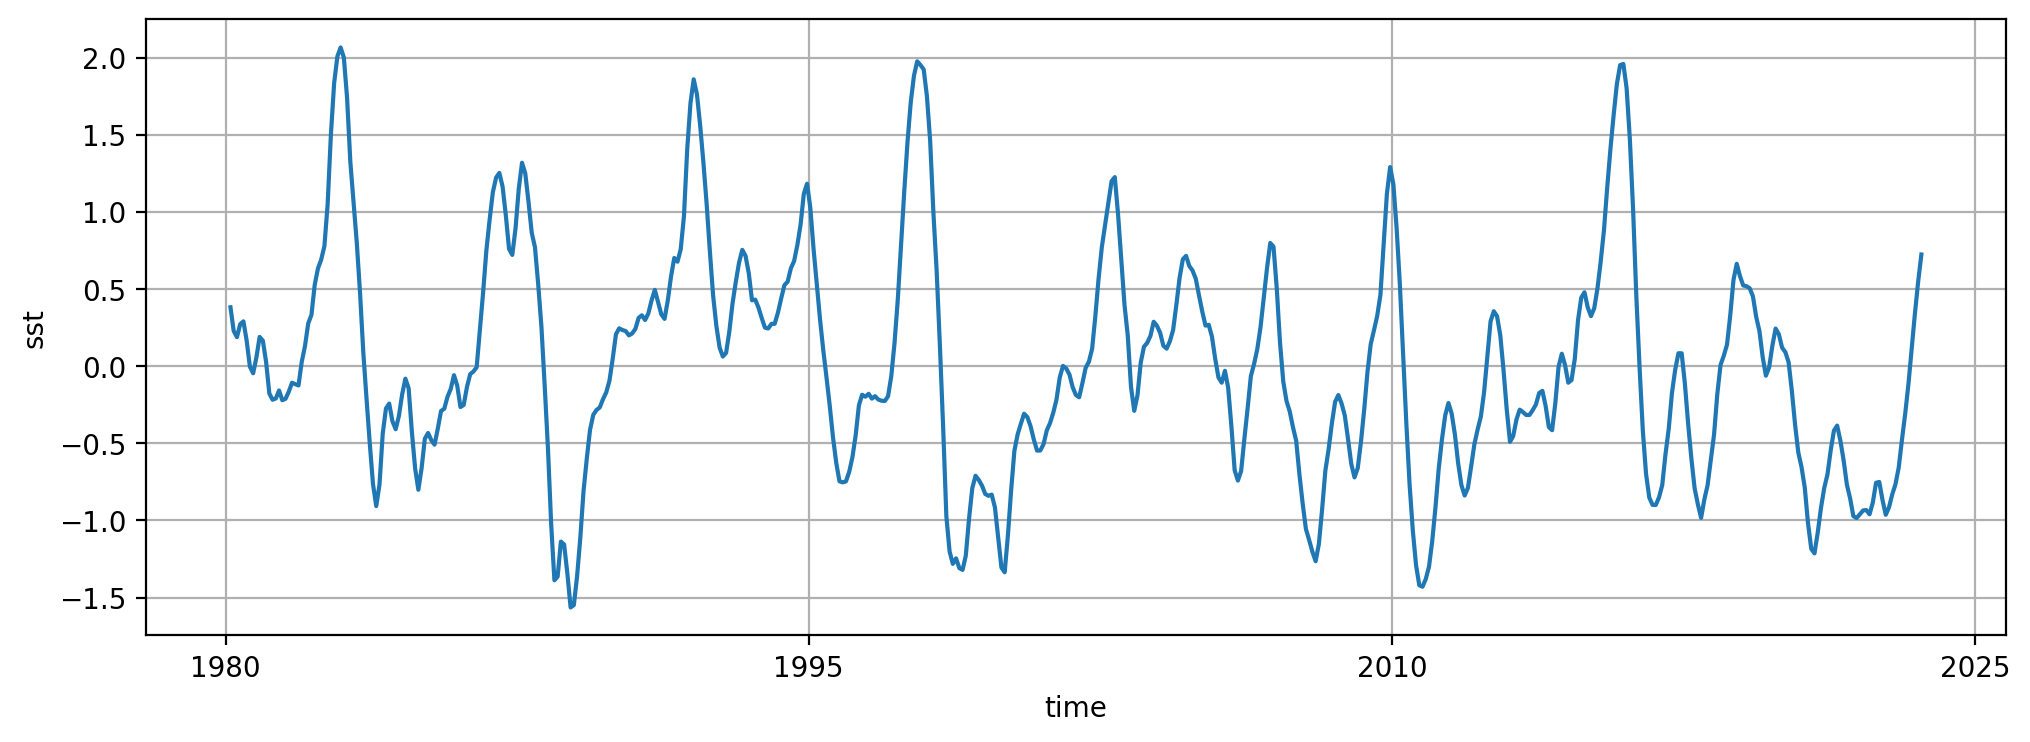

In [10]:
obsa_tmp = obs_ds_decoded.sst.groupby('T.month') - obs_ds_decoded.sst.groupby('T.month').mean('T')
obsa_tmp.rolling(T=3, center=True).mean().plot(figsize=(12, 4))
plt.grid()

# Six active NMME models

## Update schedule

| Model          | Time   | Date |
-----------------|--------|-----------------------------------------------------------
|COLA-RSMAS-CCSM4| 9:50AM |                          MM/05/YYYY - MM/15/YYYY |
|NCEP-CFSv2      | - |        Daily                   |
|CanSIPSv2      | 10:30AM                  |        MM/01/YYYY - MM/06/YYYY |
|GFDL-SPEAR     | 5:50PM                   |        MM/05/YYYY - MM/15/YYYY |
|NASA-GEOSS2S   | 5:45PM                   |        MM/05/YYYY - MM/15/YYYY |

In [11]:
# We will make a list of data sets and then merge them
ds_list = []

# start and end dates of mask for the 1991-2020 climatology
import cftime 
clim_start = cftime.Datetime360Day(1991, 1, 16, 0, 0, 0, 0)
clim_end = cftime.Datetime360Day(2020, 12, 16, 0, 0, 0, 0)

## Strategy
1. Read hindcast and forecast, without decoding times, then concat along S dimension
2. Add model dimension
3. Shift by 272.15 if needed.
4. Concat all the data sets
5. Add obs that match the forecasts
6. Define a target time T = S + L
7. Decode times (T = S + L only works before decoding)
8. Compute forecast and observation anomalies (only works after decoding)
9. Forecast Nino 3.4 is `sst` and `ssta`. Observations are `obs` and `obsa`.

## 0. CanSIPS-IC3 = GEM-NEMO + CanCM4i

765.0


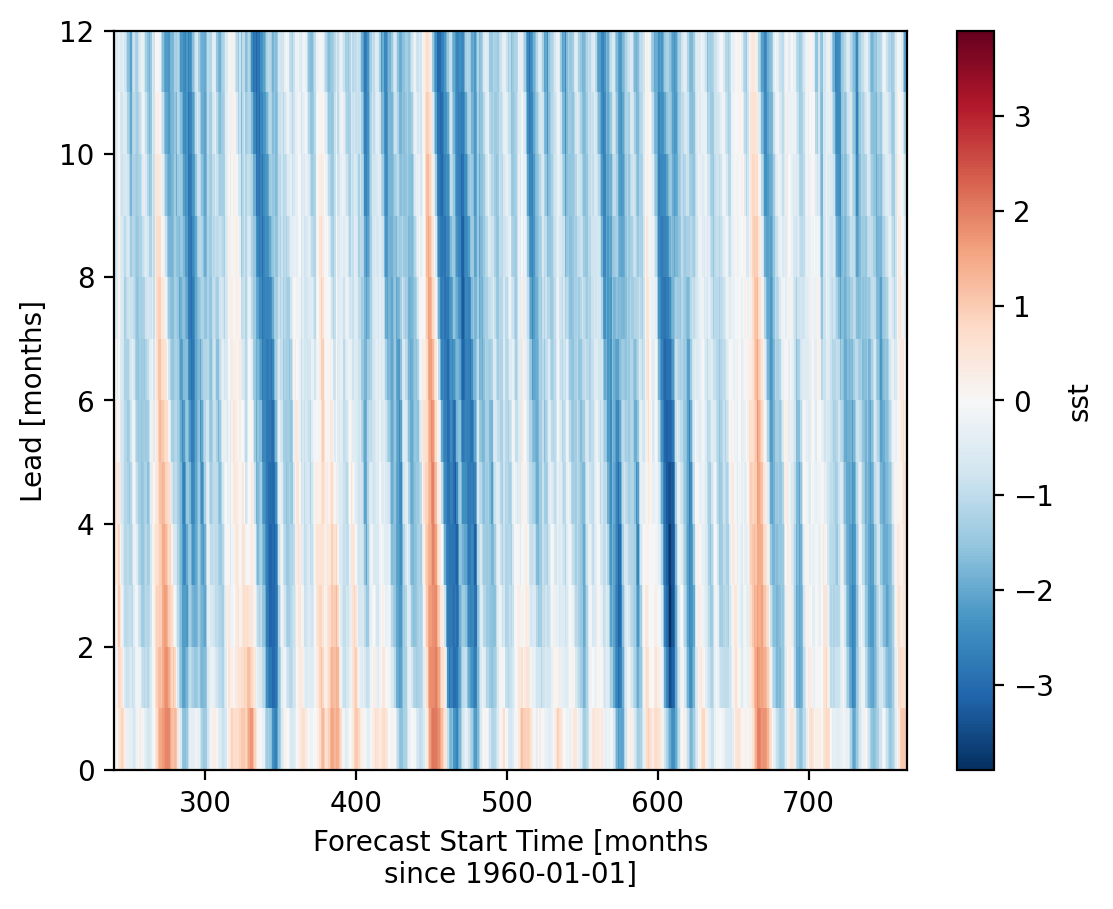

In [12]:
#GEM-NEMO
# E. Becker "The first 10 ensemble members are GEM-NEMO and 11-20 are cancm4i."
model = 'CanSIPS-IC3'
# hindcast overlaps with realtime, I cut it off at Sep 2021
h_url = nmme_url + '.CanSIPS-IC3/.HINDCAST/.MONTHLY/.sst/S/first/(000%201%20Sep%202021)/RANGE/' + n34_url + 'dods'
# forecast starts Oct 2021
f_url = nmme_url + '.CanSIPS-IC3/.FORECAST/.MONTHLY/.sst/S/(Oct%202021)/last/RANGE/' + n34_url +'0/pop/dods'
#f_url = nmme_url + '.GEM-NEMO/.FORECAST/.MONTHLY/.sst/' + n34_url +'dods'

h_ds = xr.open_dataset(h_url, decode_times=False)
f_ds = xr.open_dataset(f_url, decode_times=False)
ds = xr.concat([h_ds, f_ds], dim='S')

ds['Lmax'] = len(ds.L)
ds['Mmax'] = len(ds.M)

# Don't add the model now b/c can't change later
#ds.coords['model'] = model
#ds = ds.expand_dims('model')

ds['sst'] = ds.sst

ds.sst.mean('M').plot(x='S');
print(ds.S[-1].values)

In [13]:
# keep copy for later
ds_tmp = ds.copy()

### a. GEM-NEMO

765.0


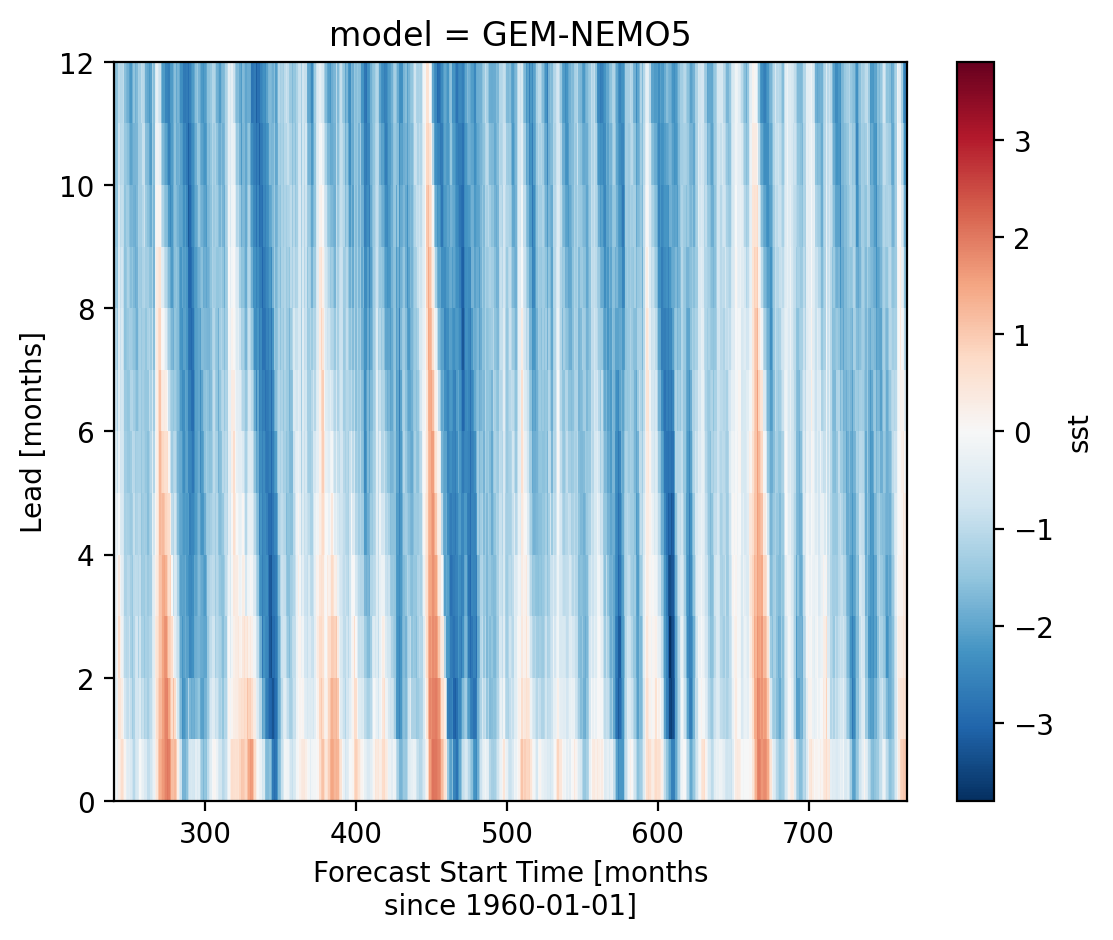

In [14]:
ds = ds_tmp.sel(M=slice(1, 10)).copy()
model = 'GEM-NEMO5'
ds.coords['model'] = model
ds = ds.expand_dims('model')

ds.sst.mean('M').plot(x='S');
print(ds.S[-1].values)

In [15]:
ds_list.append(ds)

### b. CanCM4i

765.0


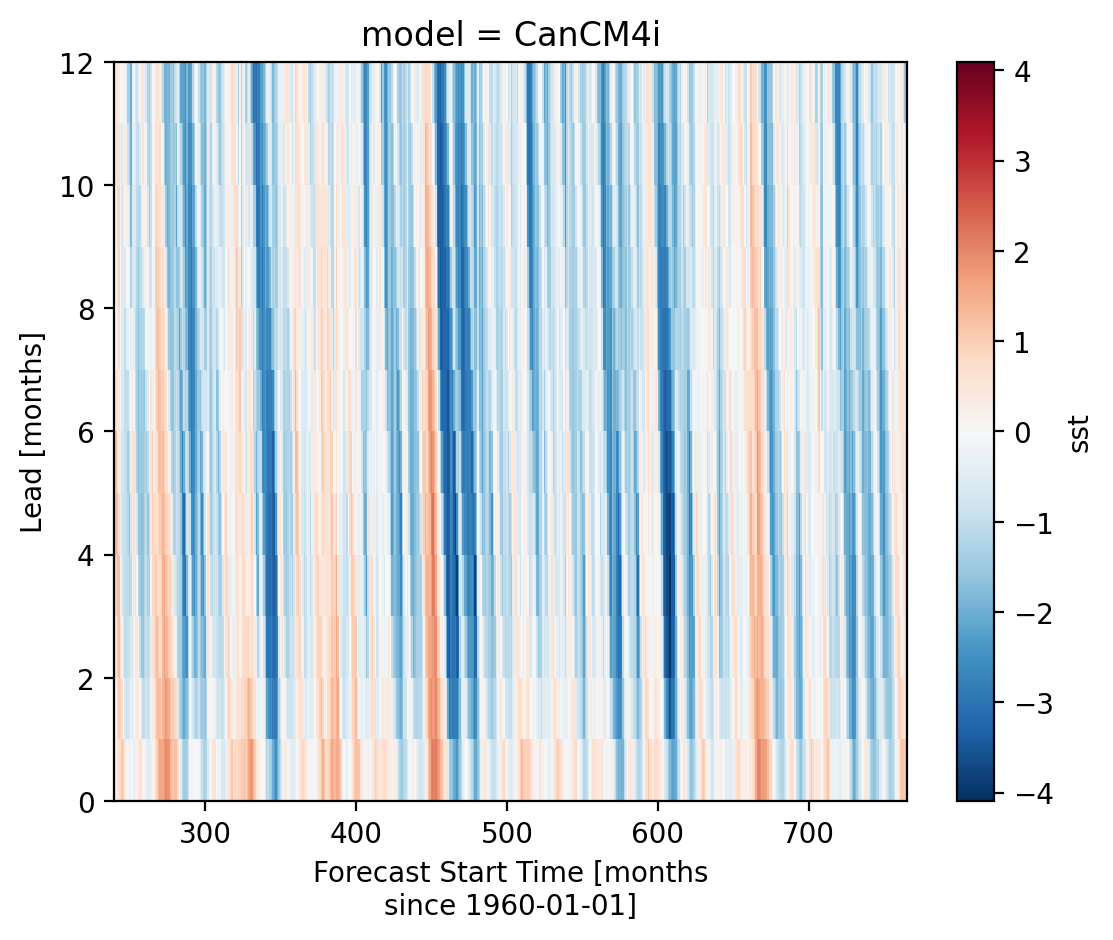

In [16]:
ds = ds_tmp.sel(M=slice(11, 20)).copy()
model = 'CanCM4i'
ds.coords['model'] = model
ds = ds.expand_dims('model')

ds.sst.mean('M').plot(x='S');
print(ds.S[-1].values)

In [17]:
ds = ds.assign_coords(M=(ds.M - 10))

In [18]:
ds_list.append(ds)

## 2. GFDL-SPEAR

765.0


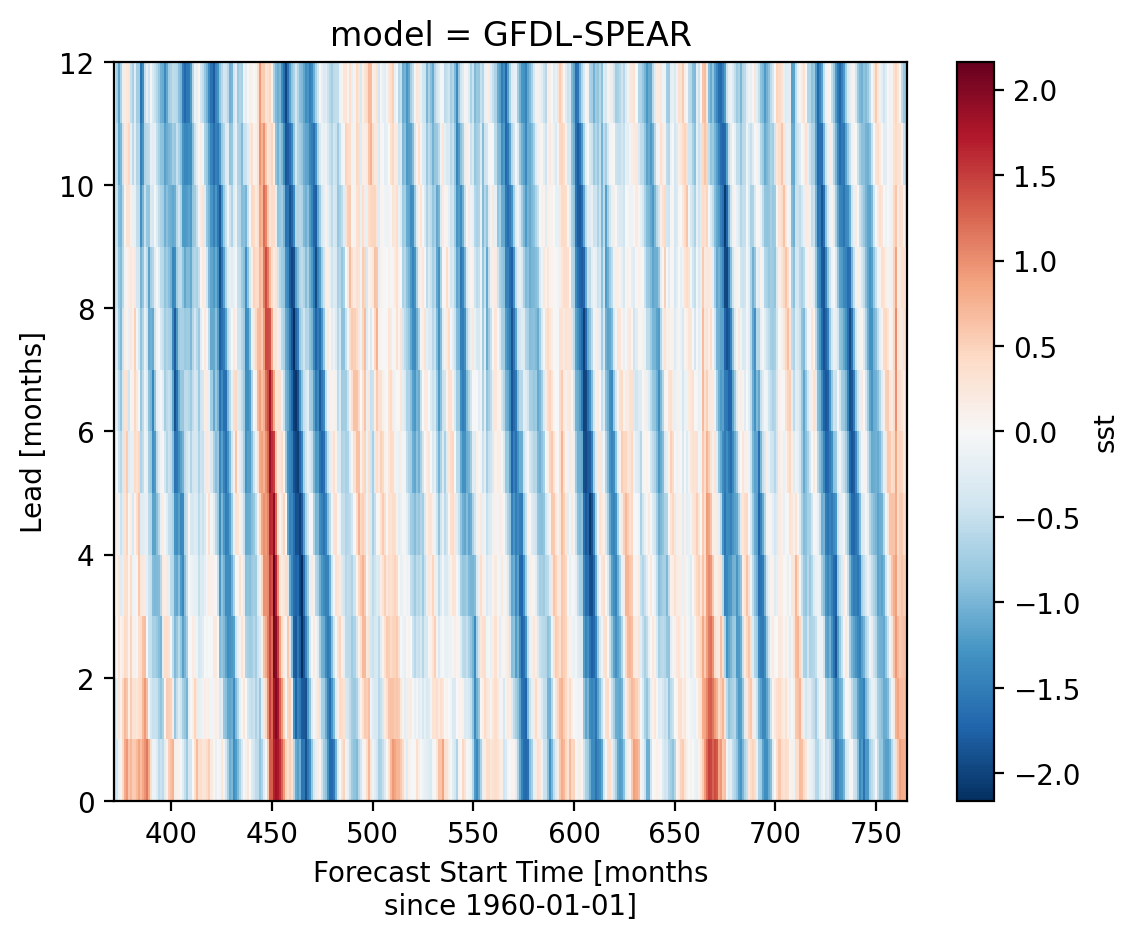

In [19]:
#GFDL-SPEAR
model = 'GFDL-SPEAR'
h_url = nmme_url + '.GFDL-SPEAR/.HINDCAST/.MONTHLY/.sst/' + n34_url + 'dods'
f_url = nmme_url + '.GFDL-SPEAR/.FORECAST/.MONTHLY/.sst/S/(Jan%202021)/last/RANGE/' + n34_url + '5/pop/dods'
h_ds = xr.open_dataset(h_url, decode_times=False)
f_ds = xr.open_dataset(f_url, decode_times=False)
ds = xr.concat([h_ds, f_ds], dim='S')

# use number of lead in hindcast
# should make lead a function of start
ds['Lmax'] = len(h_ds.L)
ds['Mmax'] = len(h_ds.M)

ds.coords['model'] = model
ds = ds.expand_dims('model')

ds.sst.mean('M').plot(x='S');
print(ds.S[-1].values)

In [20]:
ds_list.append(ds)

## 3. COLA-RSMAS-CCSM4

765.0


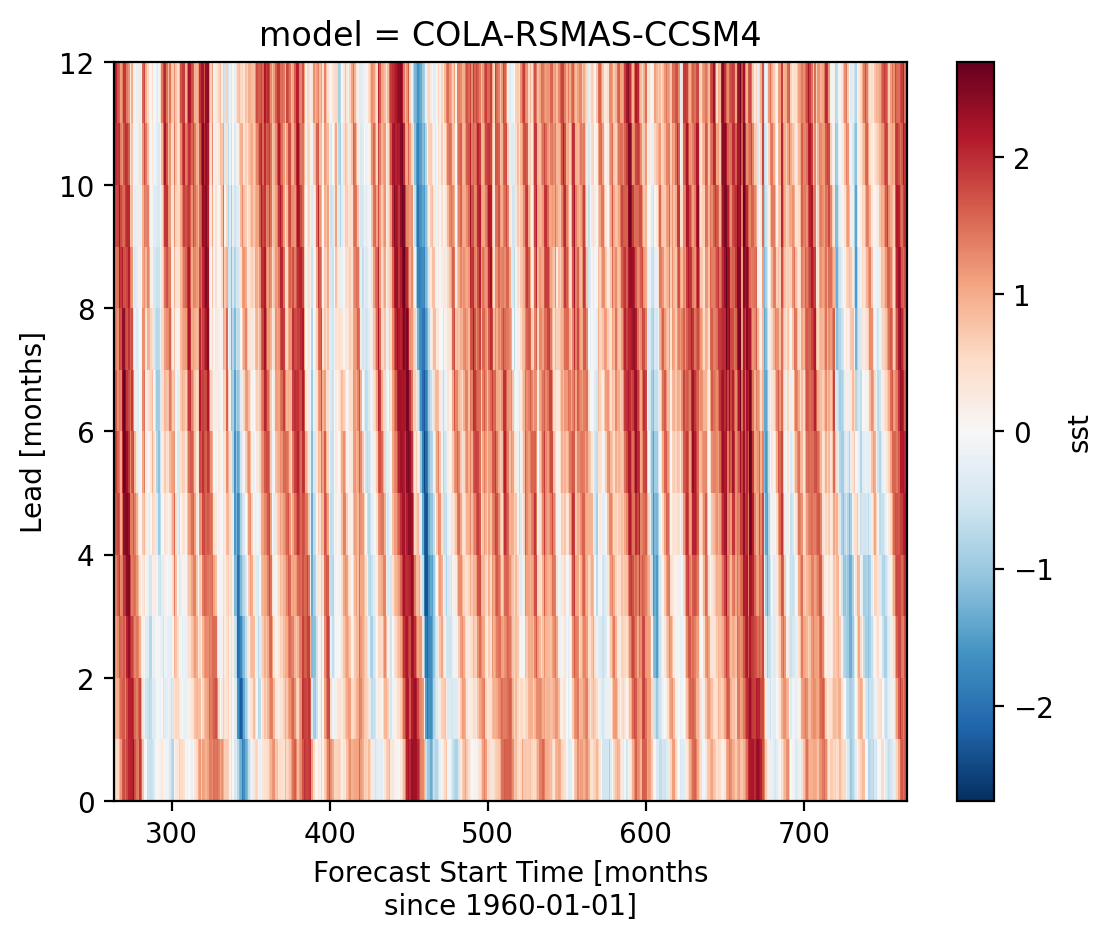

In [21]:
#COLA-RSMAS-CCSM4
model = 'COLA-RSMAS-CCSM4'
url = nmme_url + '.COLA-RSMAS-CCSM4/.MONTHLY/.sst/' + n34_url + '5/pop/dods'
ds = xr.open_dataset(url, decode_times=False)

ds['Lmax'] = len(ds.L)
ds['Mmax'] = len(ds.M)

ds.coords['model'] = model
ds = ds.expand_dims('model')

ds.sst.mean('M').plot(x='S');
print(ds.S[-1].values)

In [22]:
ds_list.append(ds)

## 4. NASA-GEOSS2S

765.0


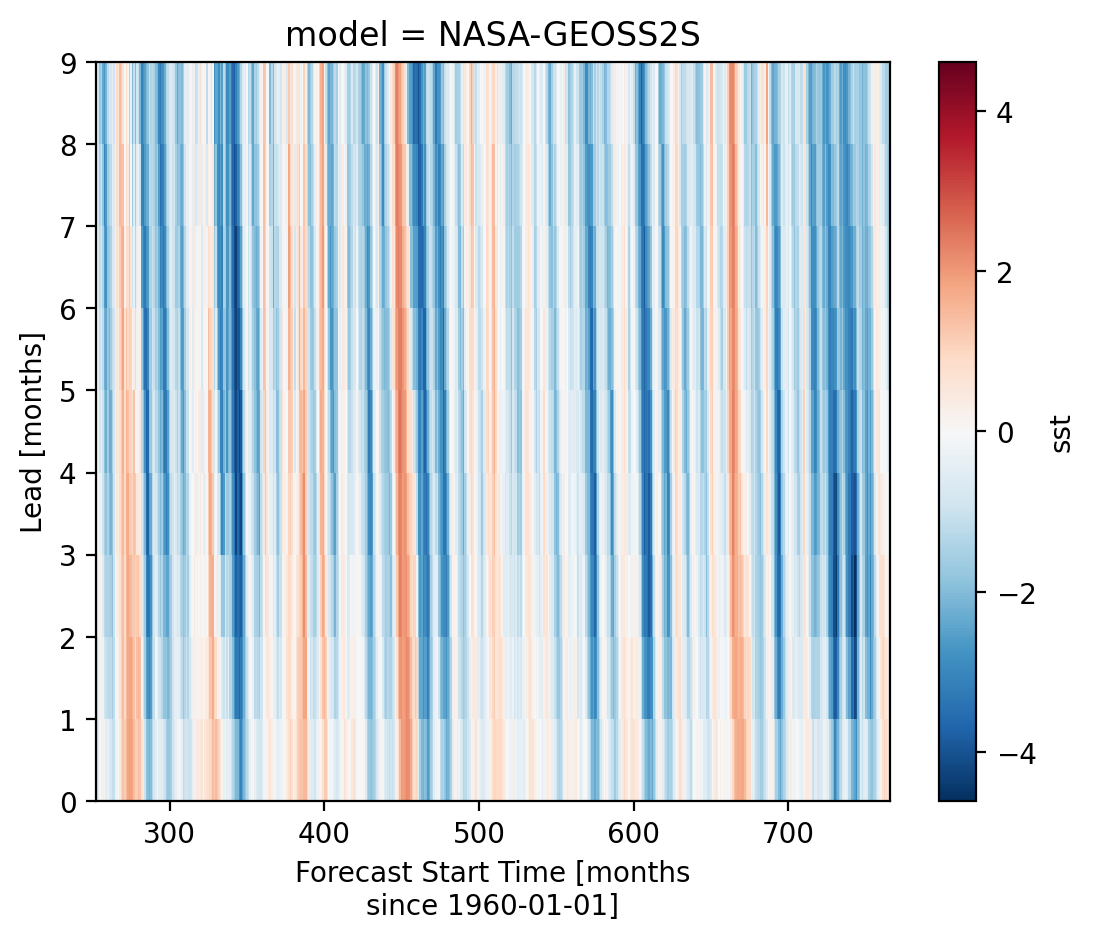

In [23]:
#NASA-GEOSS2S
model = 'NASA-GEOSS2S'

h_url = nmme_url + '.NASA-GEOSS2S/.HINDCAST/.MONTHLY/.sst/' + n34_url +'dods'
f_url = nmme_url + '.NASA-GEOSS2S/.FORECAST/.MONTHLY/.sst/' + n34_url +'2/pop/dods'
h_ds = xr.open_dataset(h_url, decode_times=False)
f_ds = xr.open_dataset(f_url, decode_times=False)
ds = xr.concat([h_ds, f_ds], dim='S')

# use number of leads in hindcast
# should make lead a function of start?
ds['Lmax'] = len(ds.L)
ds['Mmax'] = len(h_ds.M)

ds.coords['model'] = model
ds = ds.expand_dims('model')

ds.sst.mean('M').plot(x='S');
print(ds.S[-1].values)

In [24]:
ds_list.append(ds)

## 5. NCEP-CFSv2
Compute anaomlies by removing 2 forecast climatologies. One for 1982-1998 and one for 1999-2020.

765.0


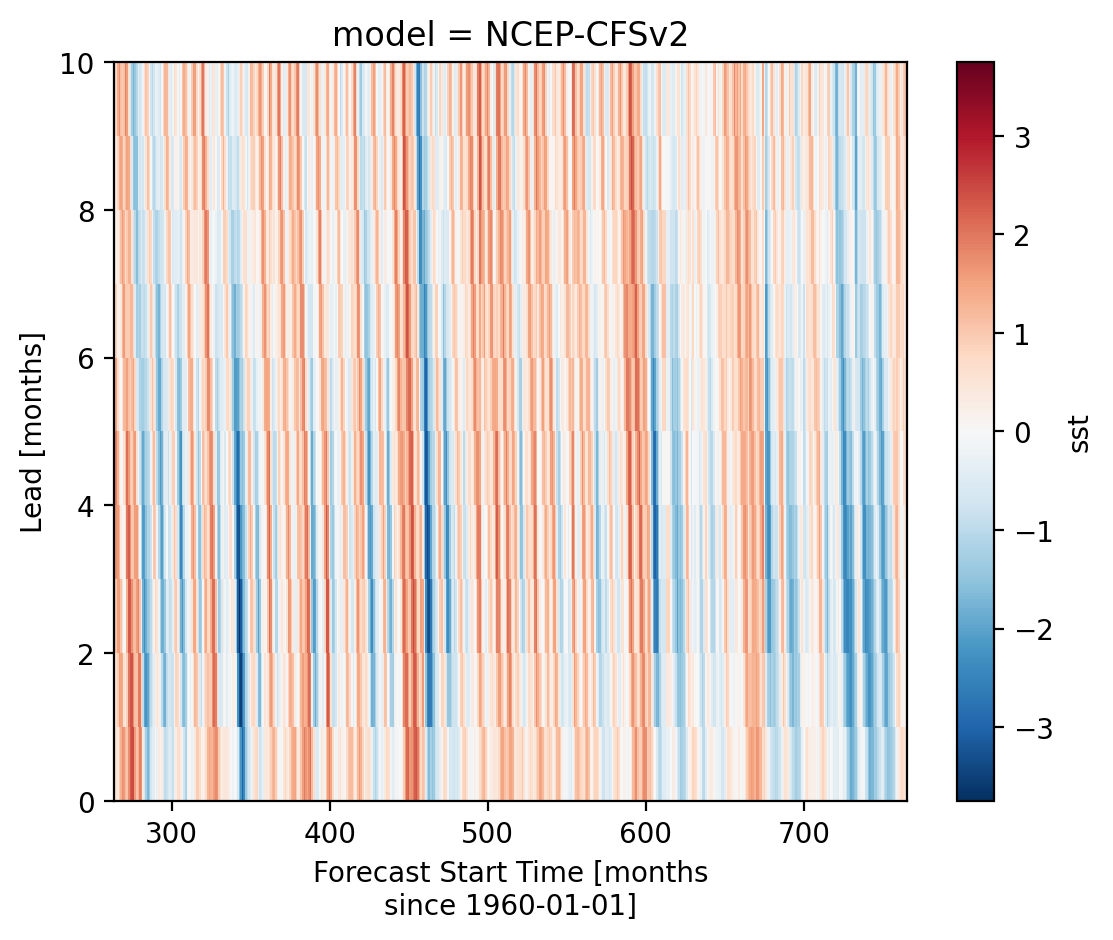

In [25]:
#NCEP-CFSv2
model = 'NCEP-CFSv2'
h_url = nmme_url + '.NCEP-CFSv2/.HINDCAST/.MONTHLY/.sst/' + n34_url +'dods'
f_url = nmme_url + '.NCEP-CFSv2/.FORECAST/.PENTAD_SAMPLES/.MONTHLY/.sst/' + n34_url +'dods'
h_ds = xr.open_dataset(h_url, decode_times=False)
f_ds = xr.open_dataset(f_url, decode_times=False)
ds = xr.concat([h_ds, f_ds], dim='S')

ds['Lmax'] = len(ds.L)
ds['Mmax'] = len(ds.M)
ds['Mmax'] = 24

ds.coords['model'] = model
ds = ds.expand_dims('model')

ds.sst.mean('M').plot(x='S');
print(ds.S[-1].values)

In [26]:
ds_list.append(ds)

In [27]:
len(ds_list)

6

# Multimodel ensemble

In [28]:
ds = xr.merge(ds_list)

## Target time and matching observations 

In [29]:
# add target time and observations
T = ds.L + ds.S 
ds["obs"] = (("L", "S"), obs.sel(T=T).data)
# nino 3.4 1991-2020 used for scaling
ds["scaling"] = (("L", "S"), scaling.sel(T=T).data)

ds['target'] = T
ds.target.attrs['units']  = ds.S.attrs['units']
ds.target.attrs['calendar']  = '360_day'

## Decode time

In [30]:
ds = decode_cf(ds, 'S')

## Anomalies 

### 1991-2020 climatology

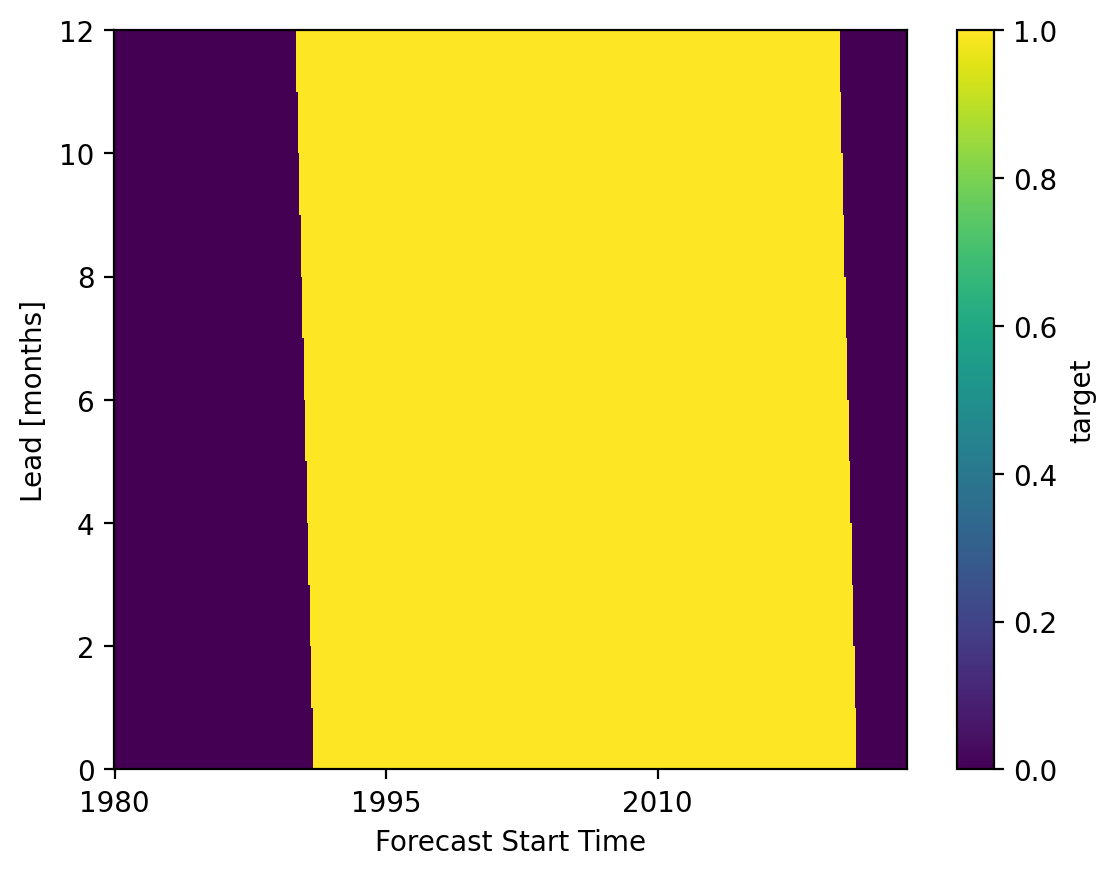

In [31]:
# climo period by target
climo_1991_2020 = (ds.target >= clim_start ) & (ds.target <= clim_end)
climo_1991_2020.plot();

In [32]:
TwoClimModels = ['COLA-RSMAS-CCSM4', 'NCEP-CFSv2']
OneClimModels = ds.model[~ds.model.isin(TwoClimModels)].values
print(TwoClimModels)
print(OneClimModels)

['COLA-RSMAS-CCSM4', 'NCEP-CFSv2']
['CanCM4i' 'GEM-NEMO5' 'GFDL-SPEAR' 'NASA-GEOSS2S']


### Two-climatology models

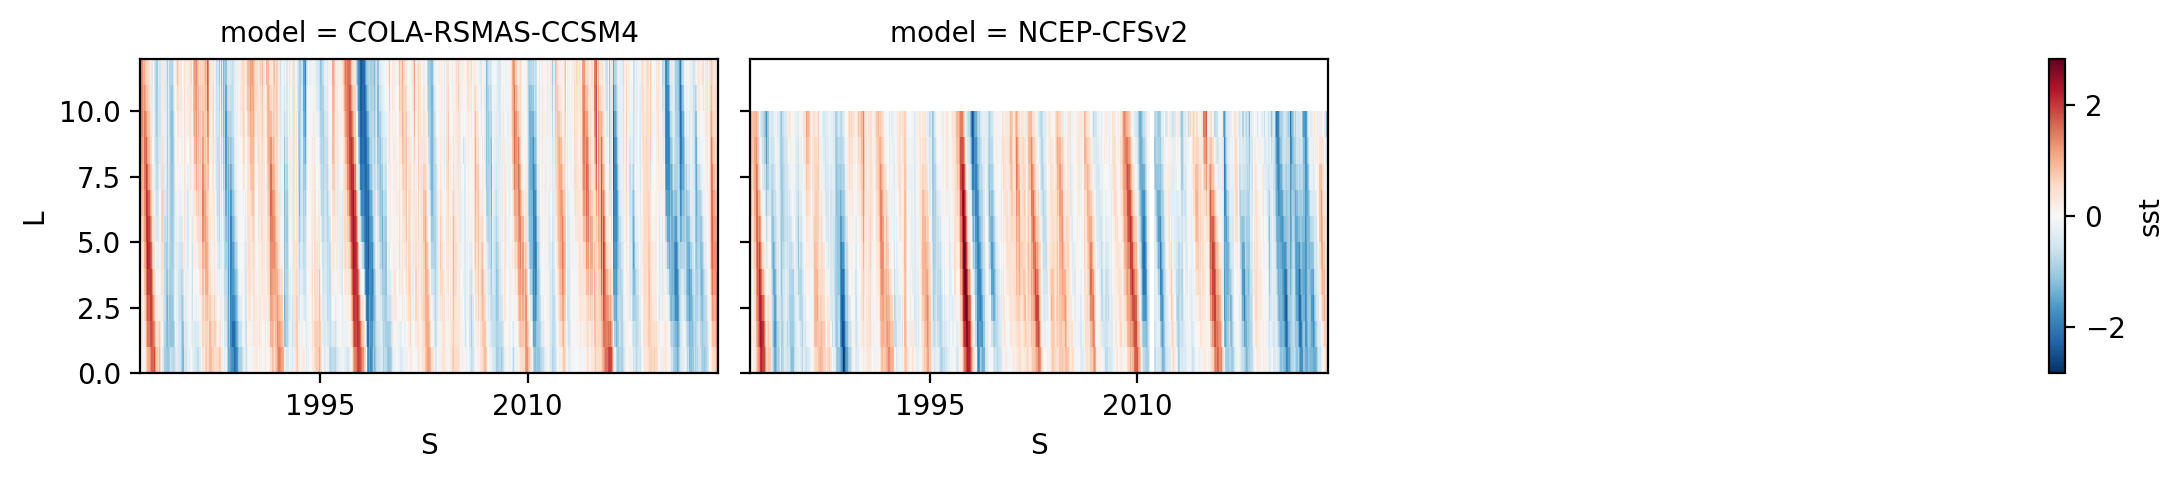

In [33]:
# two climatologies by start
f1 = ds.sel(model=TwoClimModels).sst.sel(S=slice('1982-01-01', '1998-12-01'))
ssta1 = f1.groupby('S.month') - f1.groupby('S.month').mean(('S', 'M'))

f2 = ds.sel(model=TwoClimModels).sst.sel(S=slice('1999-01-01', None))
ssta2 = f2.groupby('S.month') - f2.sel(S=slice('1999-01-01', '2020-12-01')).groupby('S.month').mean(('S', 'M'))
ssta_TwoClim = xr.concat([ssta1, ssta2], dim='S')
ssta_TwoClim.mean('M').plot(col='model', col_wrap = 3, x='S', figsize=(12, 2.5));

### One-climatology models 

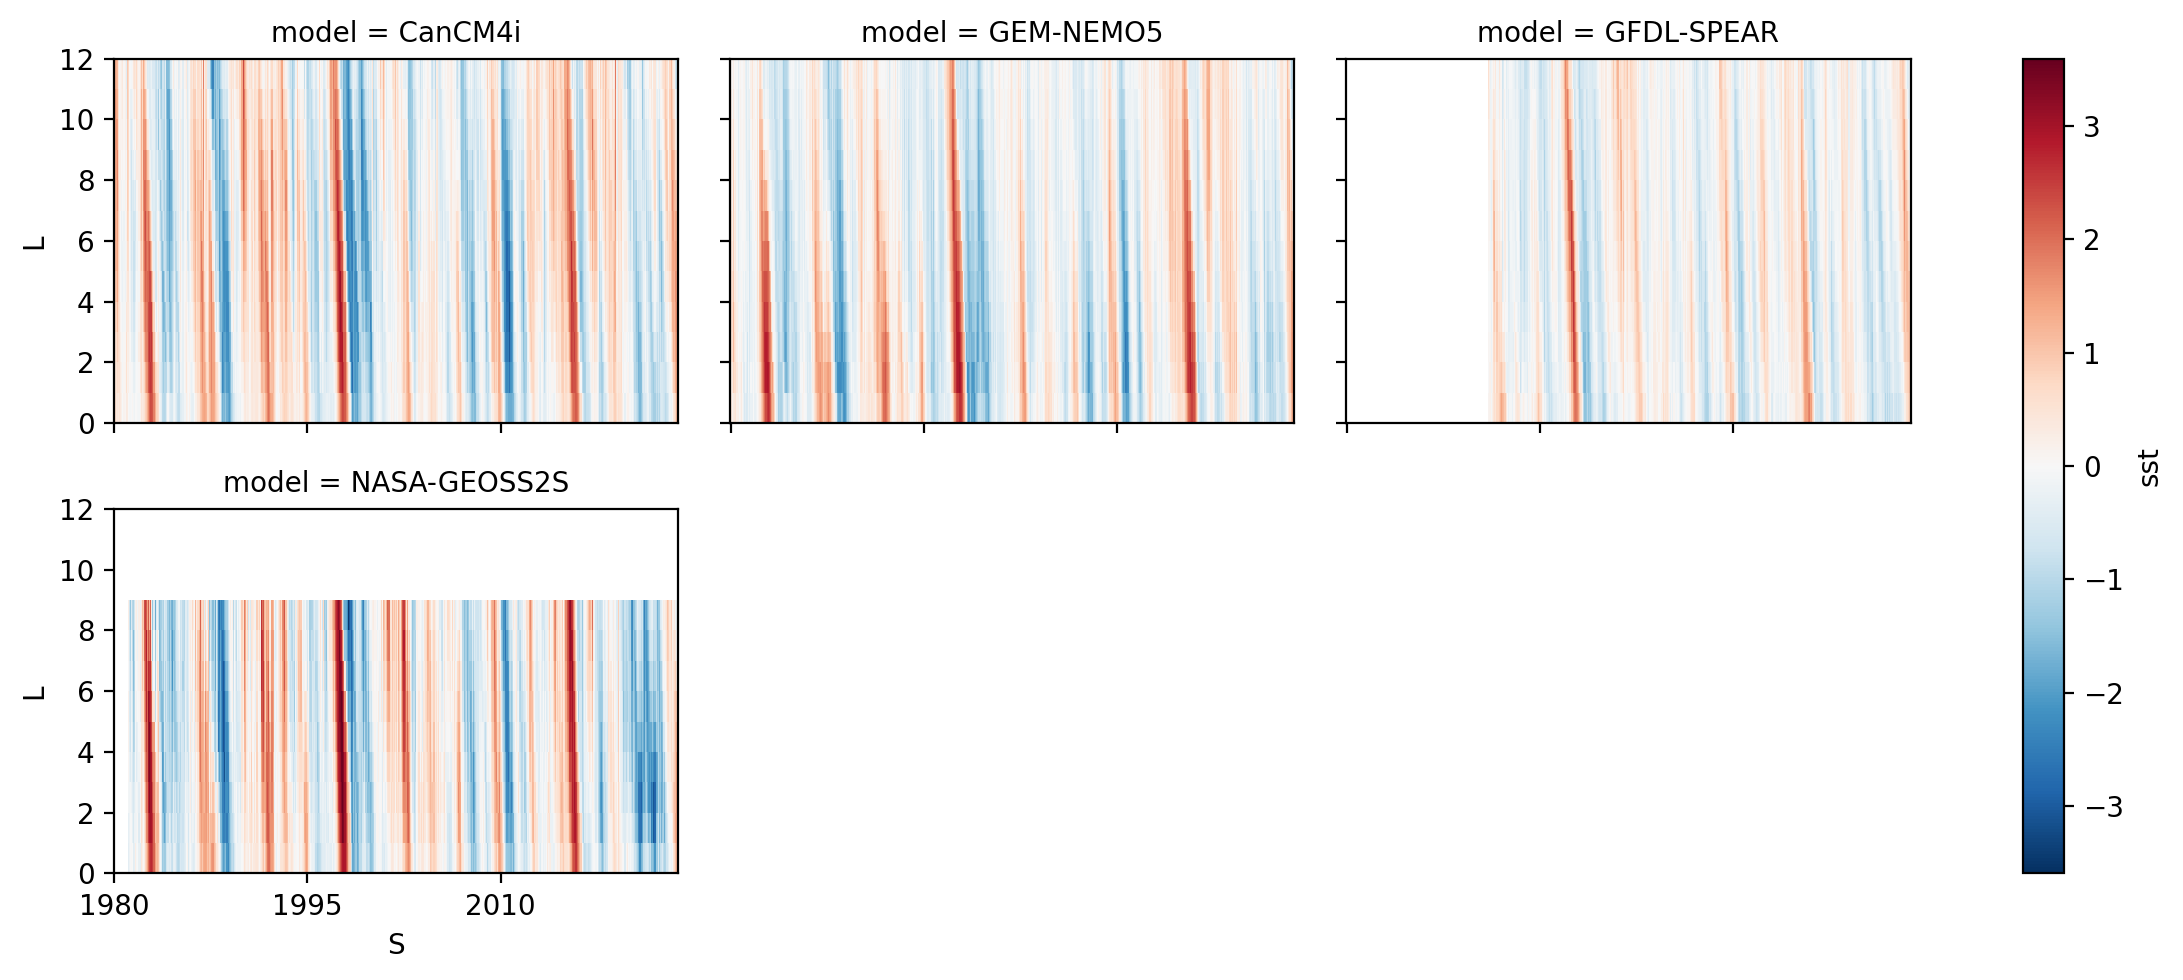

In [34]:
# forecast anomalies
f = ds.sst.sel(model=OneClimModels)
fc = f.where(climo_1991_2020)
ssta_OneClim = f.groupby('S.month') - fc.groupby('S.month').mean(('S', 'M'))
ssta_OneClim.mean('M').plot(col='model', col_wrap = 3, x='S', figsize=(12, 5));

### Merge

In [35]:
ssta = xr.concat([ssta_TwoClim, ssta_OneClim], dim='model')
ssta.attrs['long_name'] = 'ssta'

### Scaling
There are at least two ways of rescaling:
1. Scale the model relative Nino 3.4 variance to match the observed 1991–2020 Nino 3.4 variance.
2. An alternative is to scale the model relative Nino 3.4 variance to match the *model* Nino 3.4 variance.

Currently I am doing #1. Scaling does not matter for correlation skill.

In [36]:
scaling_factor = ds.scaling.where(climo_1991_2020).groupby('S.month').std('S')
ds['ssta']  = ssta.groupby('S.month') / (ssta.where(climo_1991_2020).groupby('S.month').std(['S', 'M']) / scaling_factor)
#ds['ssta'] = ssta

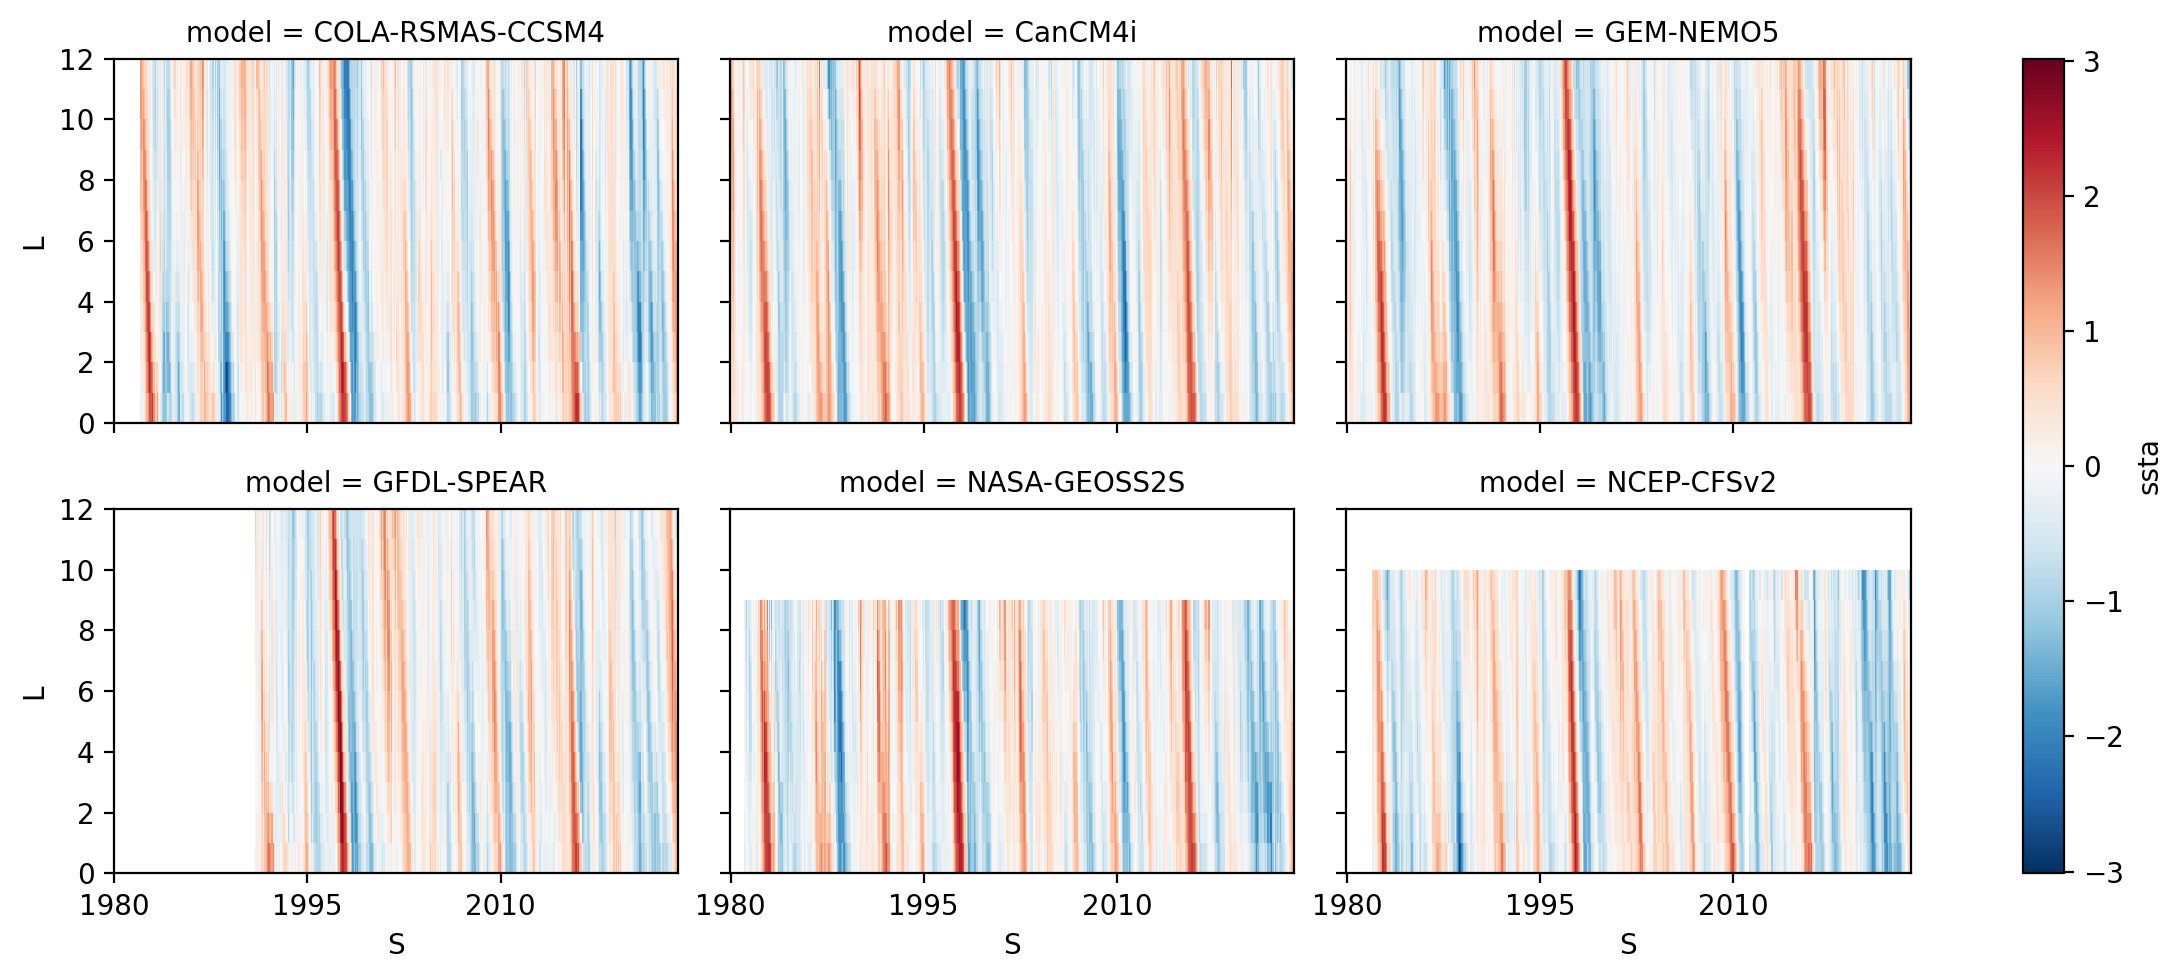

In [37]:
ds.ssta.mean('M').plot(col='model', col_wrap = 3, x='S', figsize=(12, 5));

### Observation anomalies

And scale the observation anomalies to match the observed 1991–2020 Nino 3.4 variance

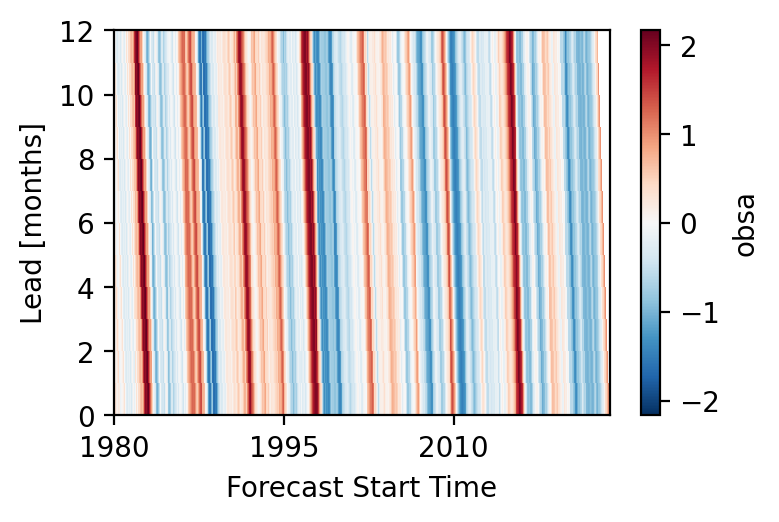

In [38]:
# climo period by target
o = ds.obs
oc = ds.obs.where(climo_1991_2020)
obsa = o.groupby('S.month') - oc.groupby('S.month').mean('S')
#ds['obsa'] = obsa
ds['obsa'] = obsa.groupby('S.month') / (oc.groupby('S.month').std('S') / scaling_factor)
del(obsa)
ds.obsa.plot(figsize=(4, 2.5));

# Save local copy (if you want, or skip)

In [39]:
ds_saved = ds.copy()

import pickle
#save a copy locally
with open('relative_n34_nmme_saved_on_disk', 'wb') as f:
    pickle.dump(ds, f, pickle.HIGHEST_PROTOCOL)

# Read local copy

In [40]:
import pickle
#read a copy 
with open('relative_n34_nmme_saved_on_disk', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    ds = pickle.load(f)

# Plot data (and other sanity checks)

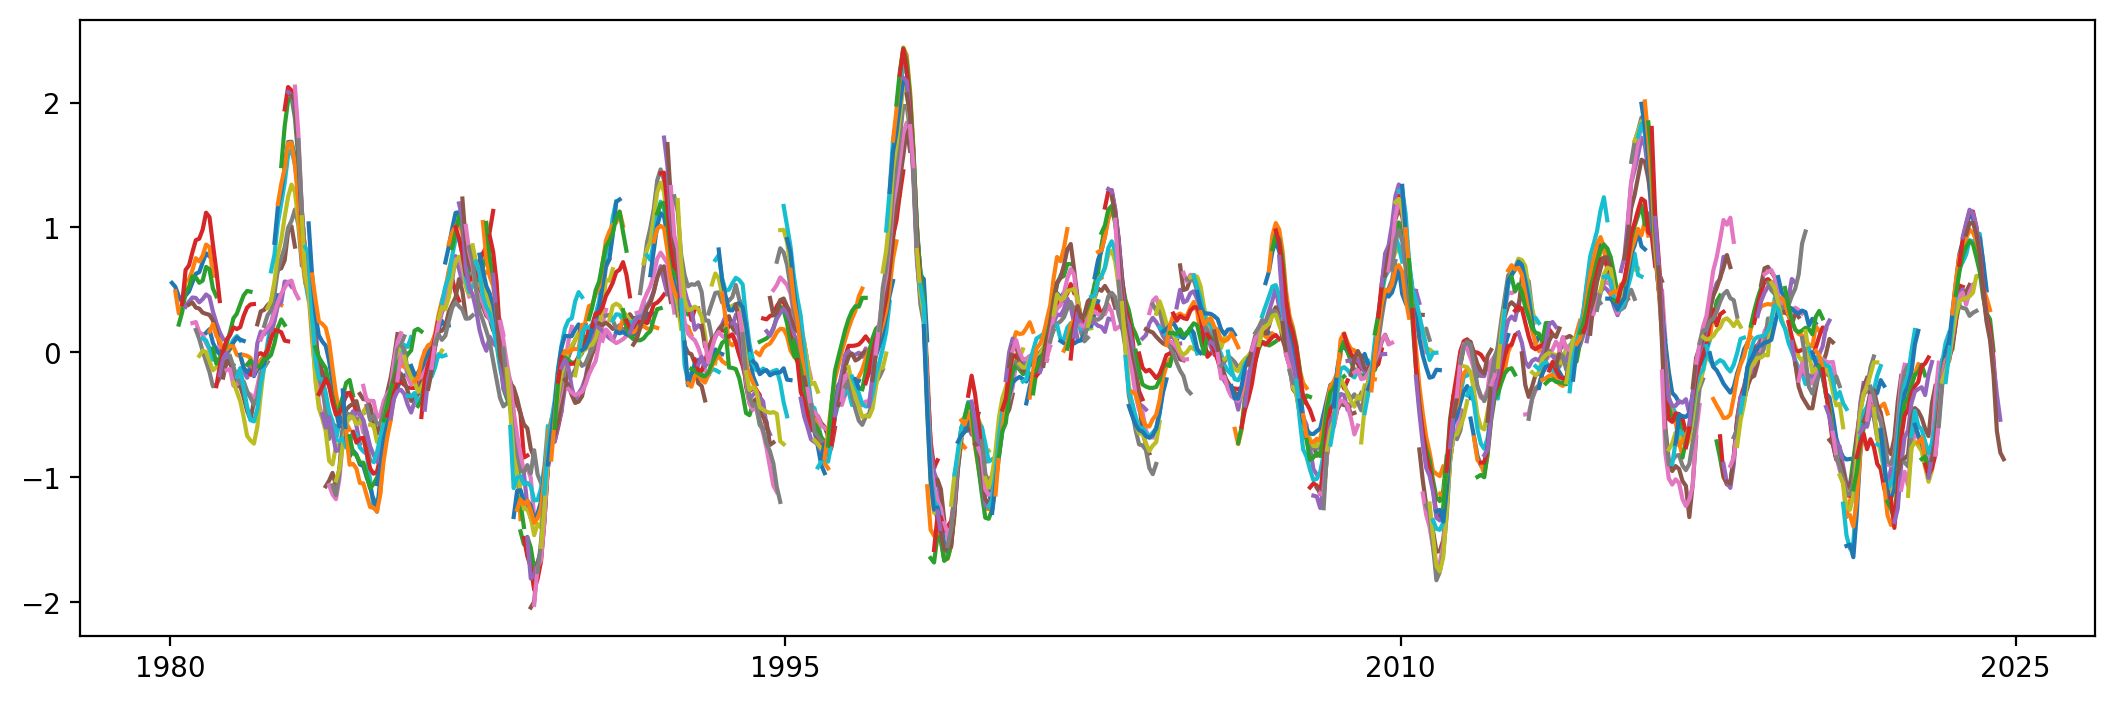

In [41]:
fig, ax = plt.subplots(figsize=(13, 4))
ax.plot(ds.target, ds.ssta.mean('M').mean('model').T)
plt.show()

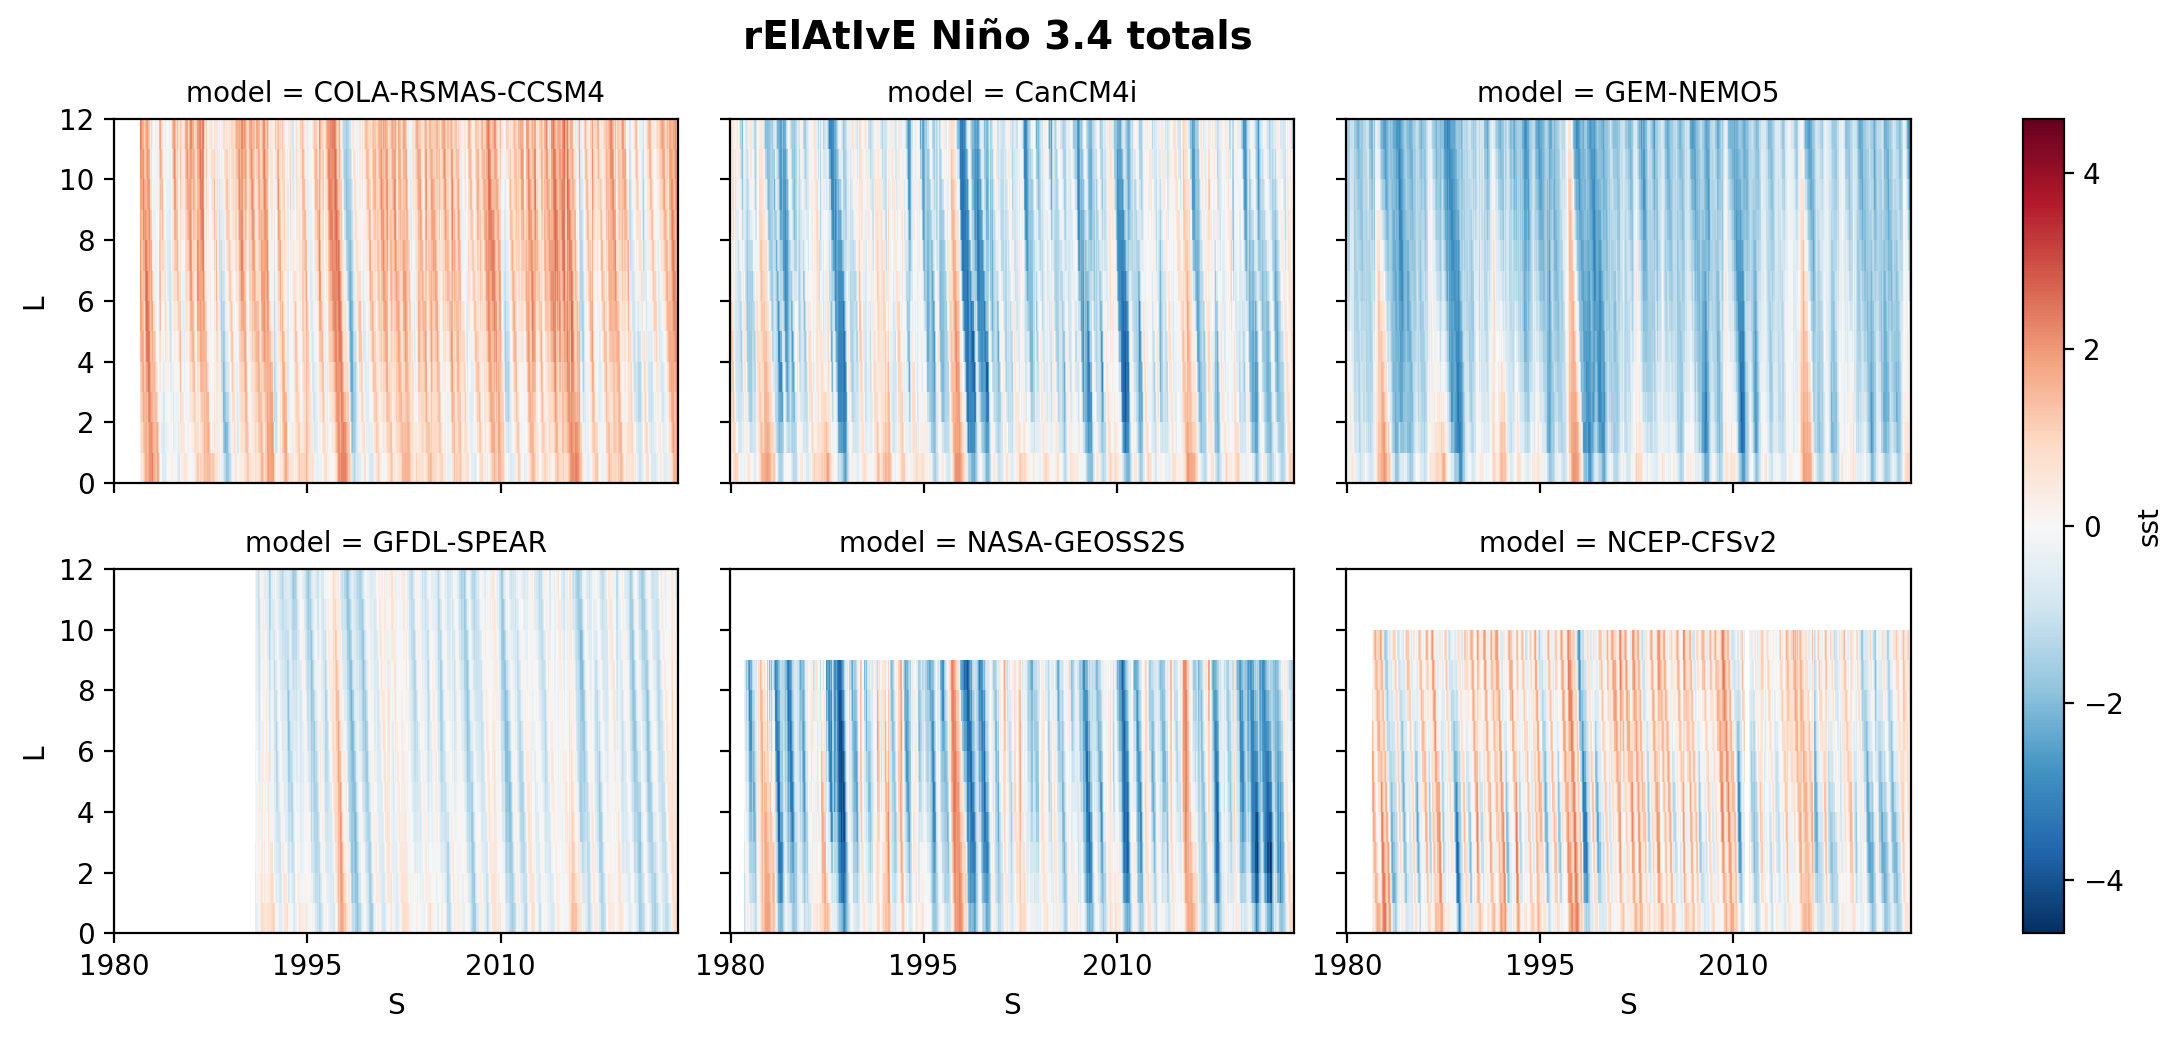

In [42]:
#Ensemble mean (total)
g = ds.sst.mean('M').plot(col='model', col_wrap = 3, x='S', figsize=(12, 5));
fig = g.fig
fig.suptitle('rElAtIvE Niño 3.4 totals', x = 0.42, y=1.03, fontsize=14, fontweight='bold');
fig.set_facecolor("white")
plt.show()

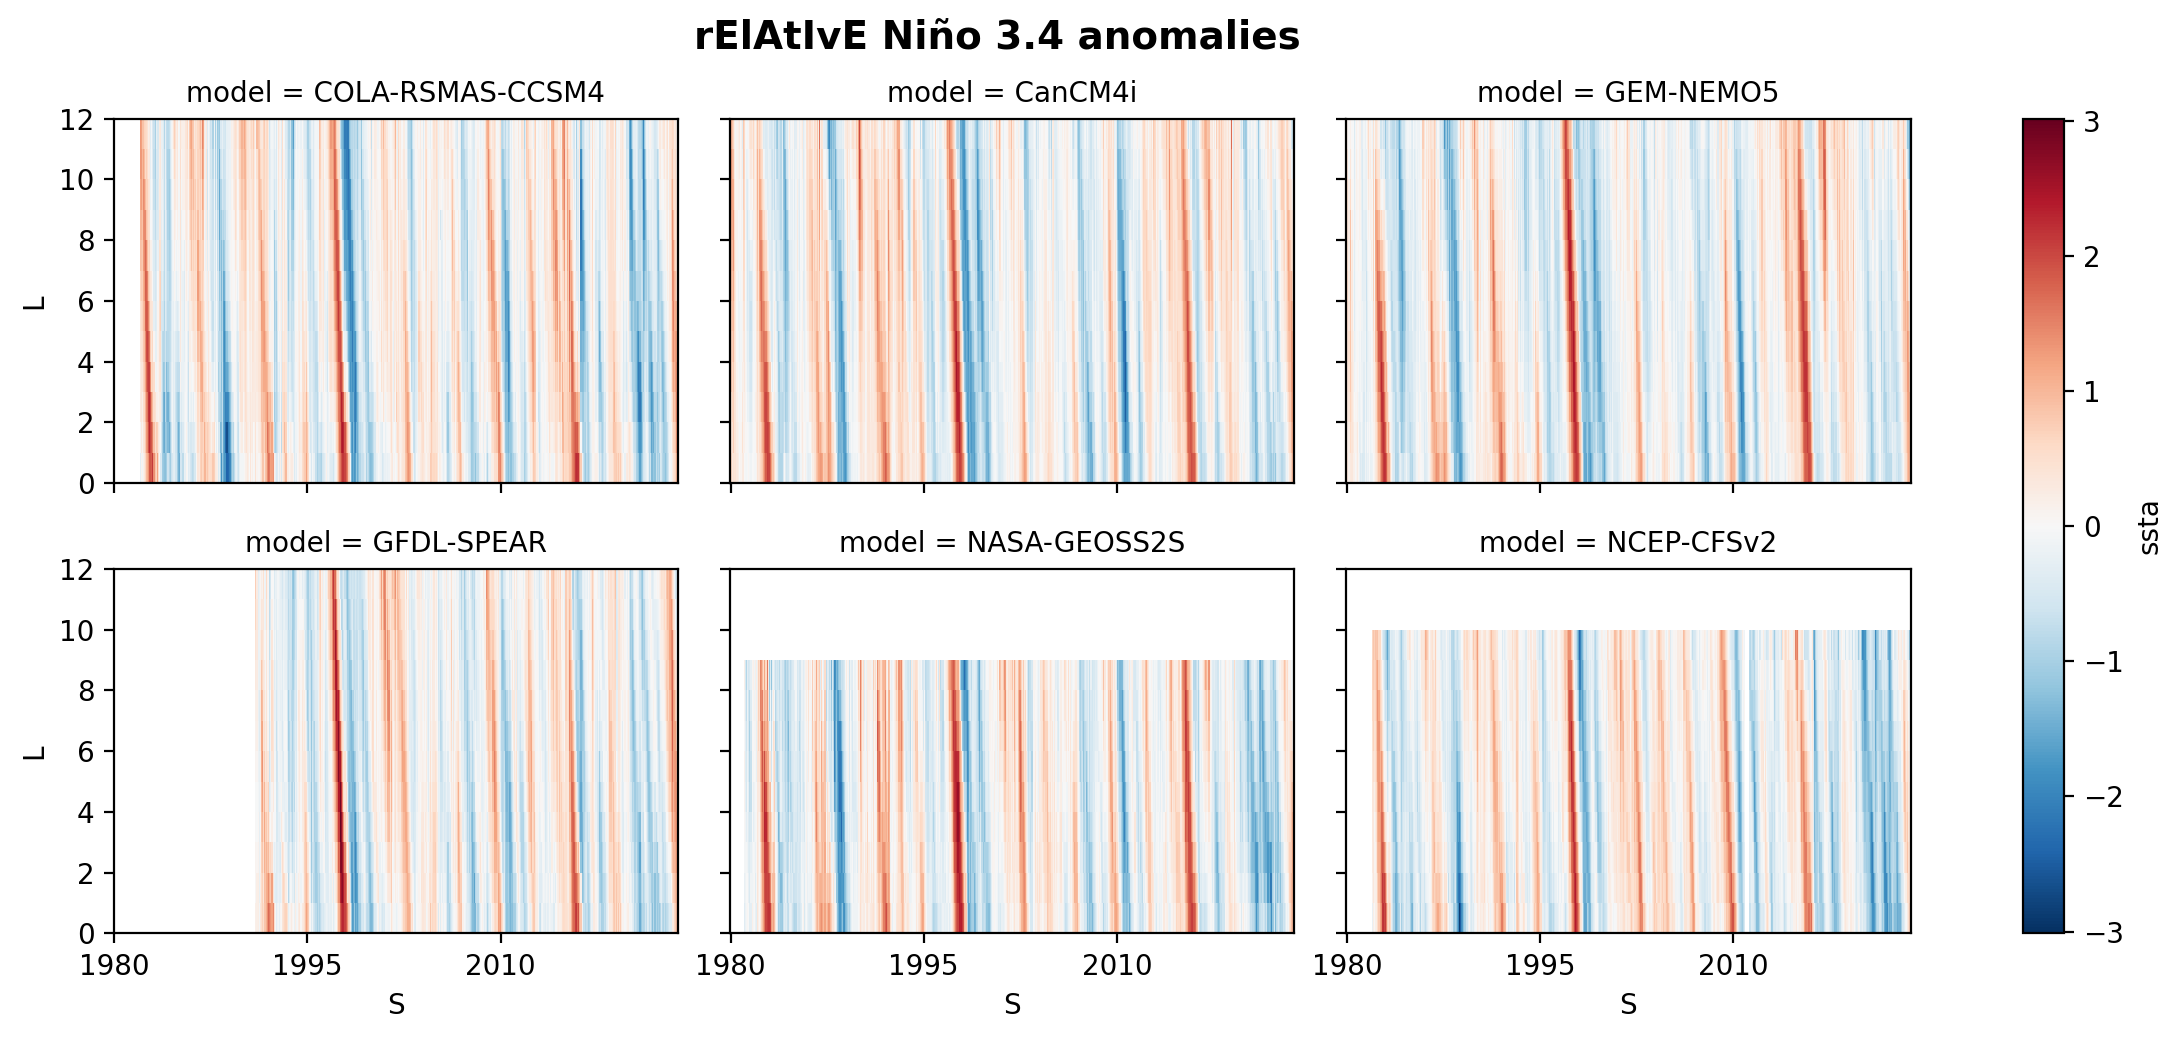

In [43]:
#Ensemble mean anomalies
g = ds.ssta.mean('M').plot(col='model', col_wrap = 3, x='S', figsize=(12, 5))
fig = g.fig
fig.suptitle('rElAtIvE Niño 3.4 anomalies', x = 0.42, y=1.03, fontsize=14, fontweight='bold');
fig.set_facecolor("white")
plt.show()

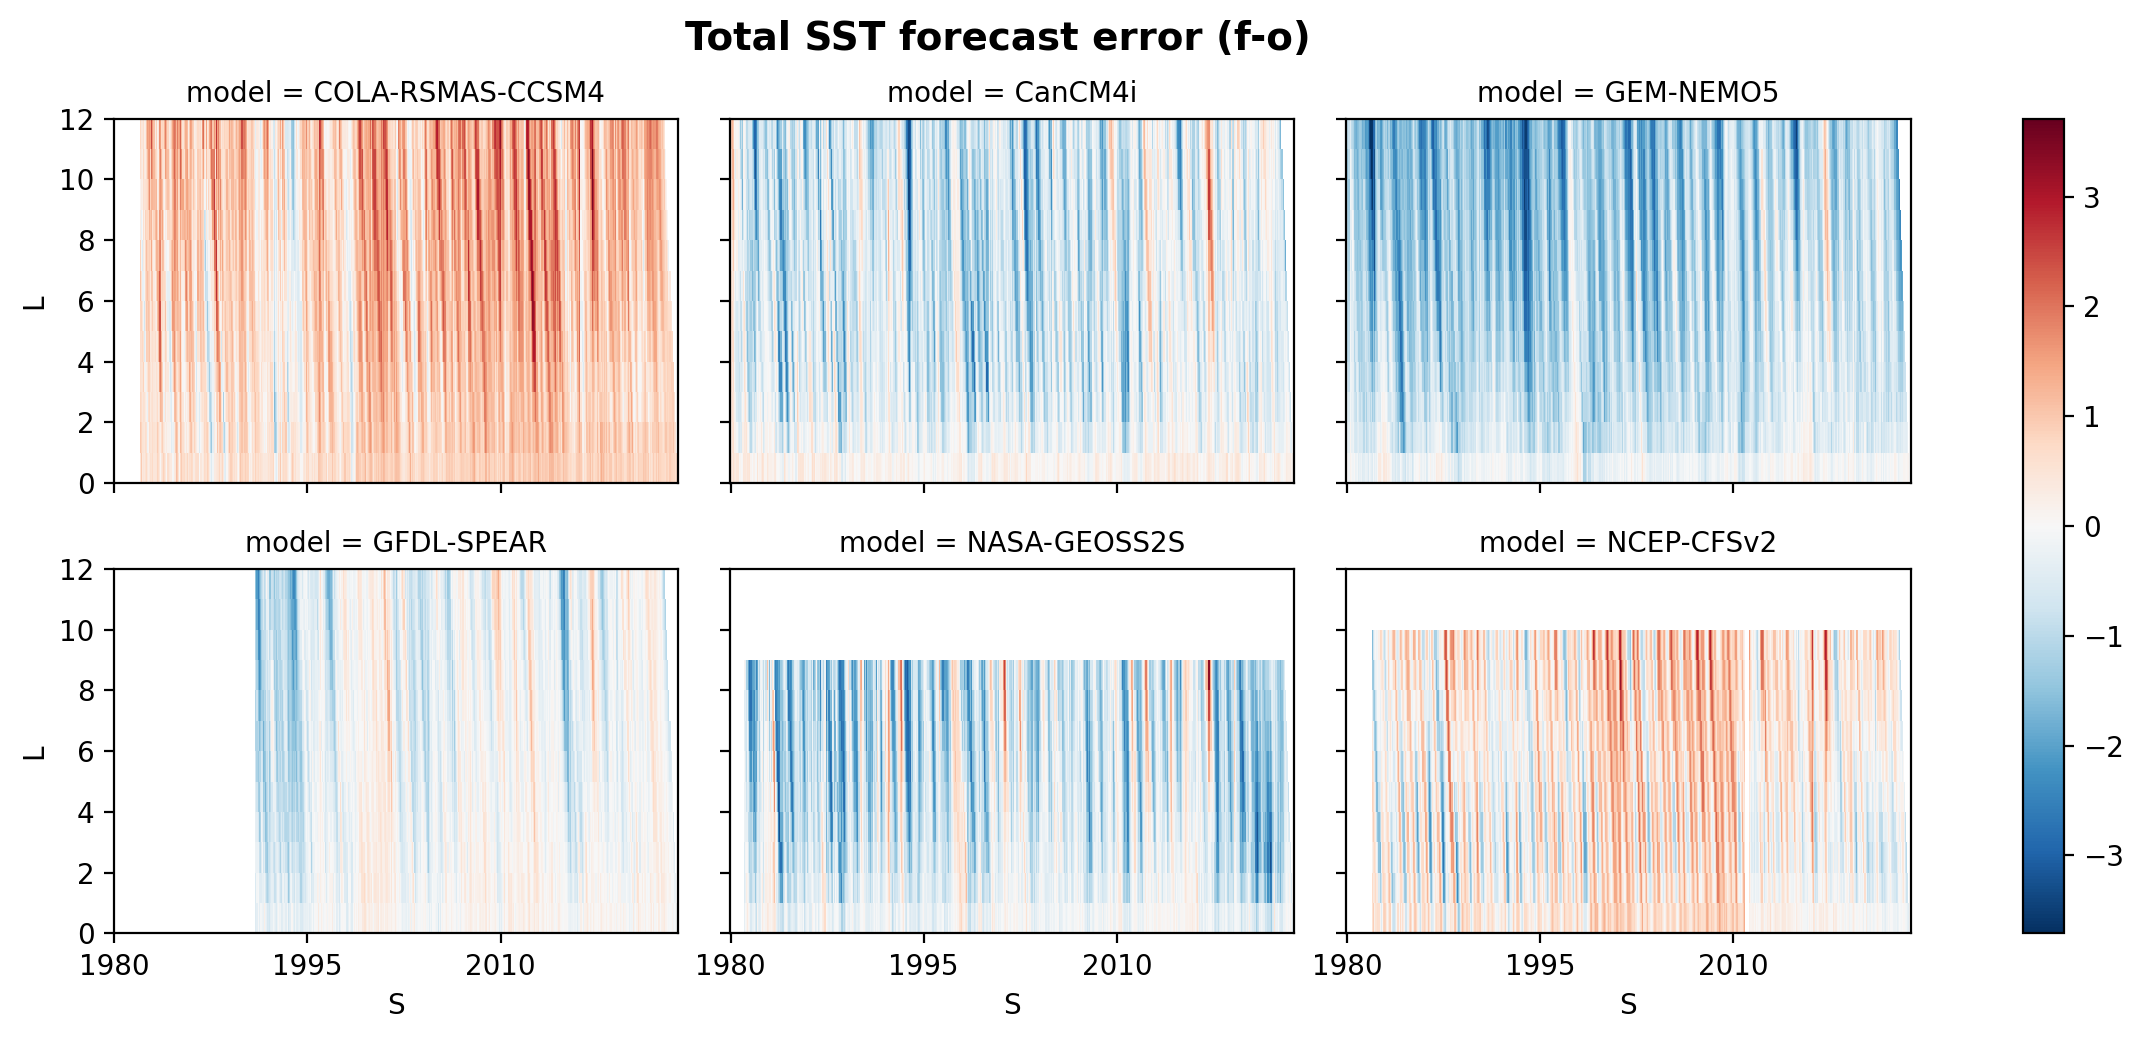

In [44]:
#Ensemble mean error (total)
g = (ds.sst.mean('M') - ds.obs).plot(col='model', col_wrap = 3, x='S', figsize=(12, 5));
fig = g.fig
fig.suptitle('Total SST forecast error (f-o)', x = 0.42, y=1.03, fontsize=14, fontweight='bold');
fig.set_facecolor("white")
plt.show()

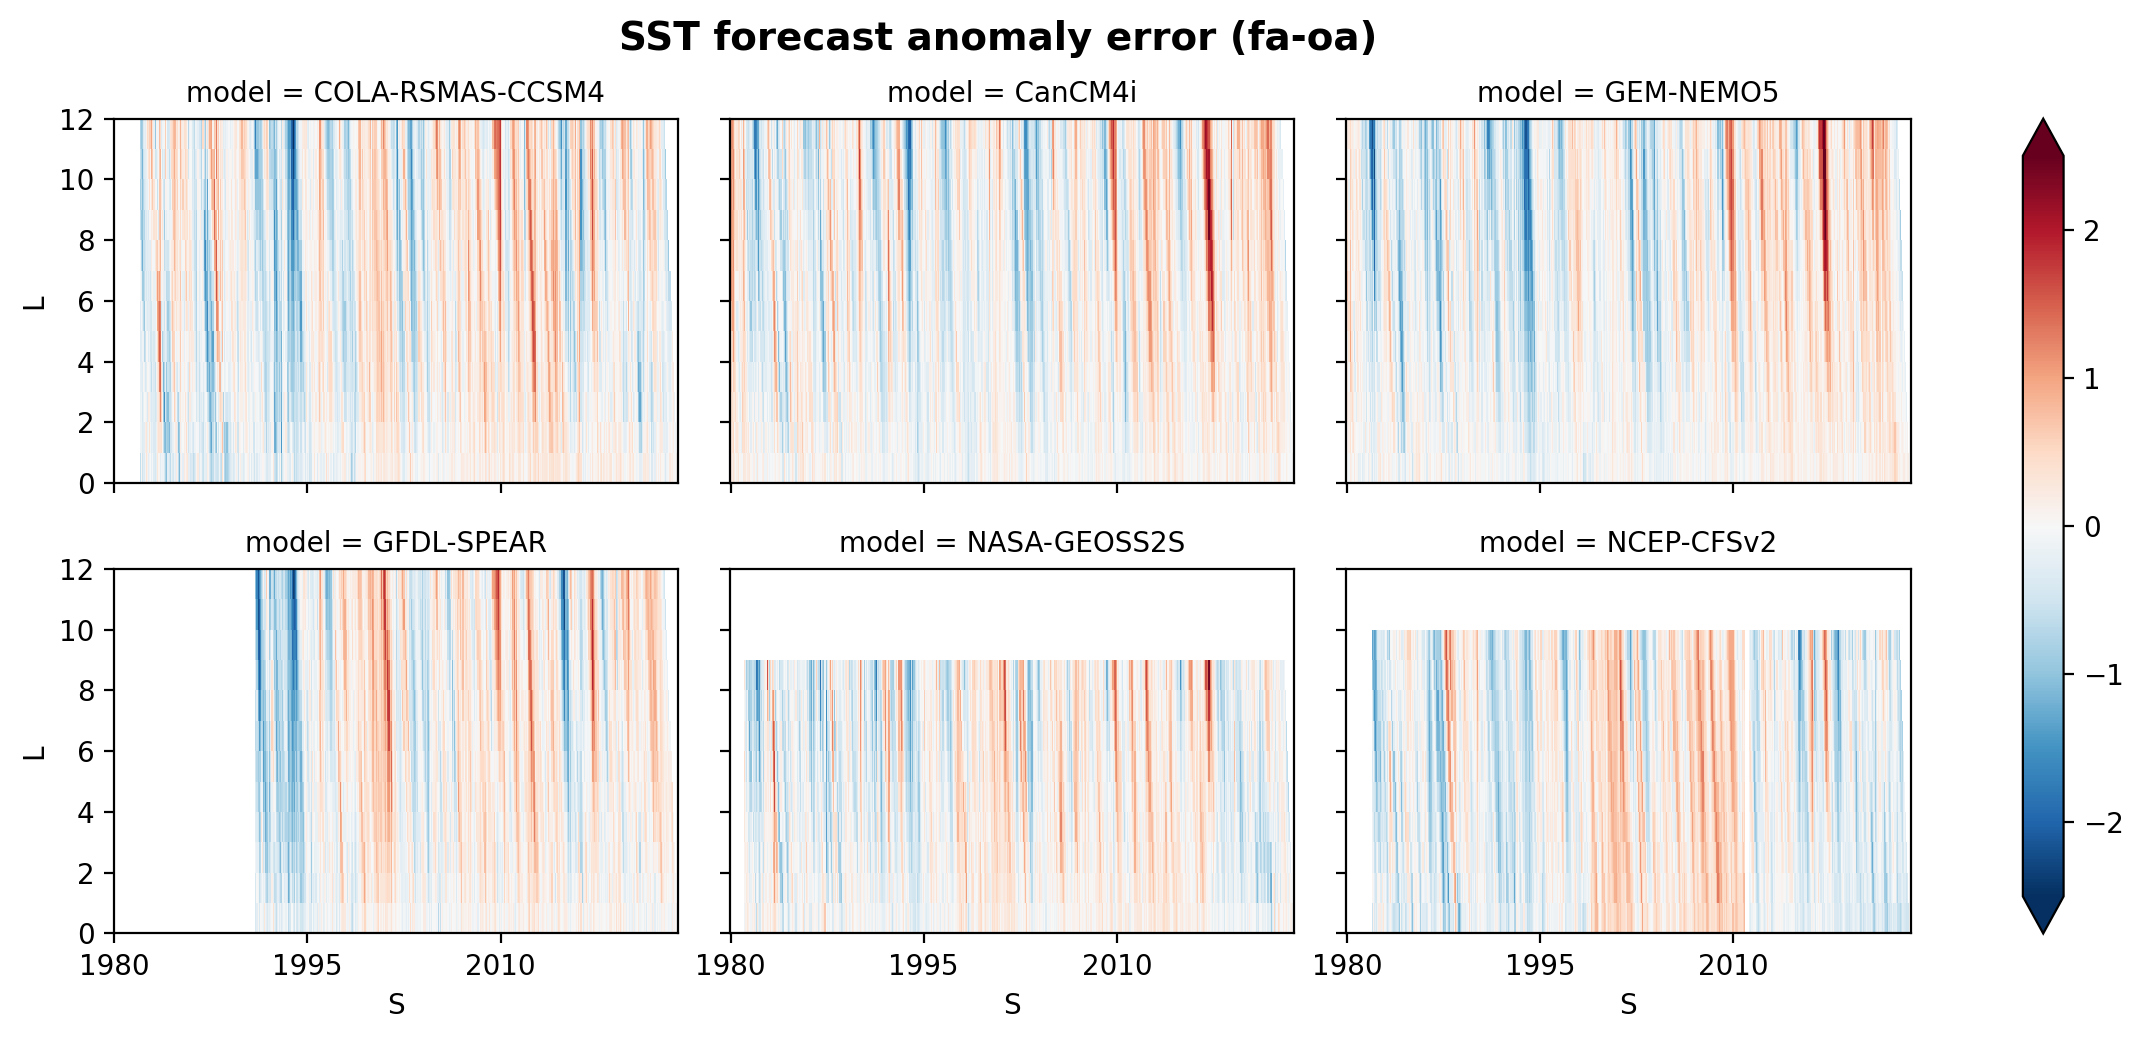

In [45]:
#Ensemble mean anomaly error
g = (ds.ssta.mean('M') - ds.obsa).plot(col='model', col_wrap = 3, x='S', vmin=-2.5, figsize=(12, 5));
fig = g.fig
fig.suptitle('SST forecast anomaly error (fa-oa)', x = 0.42, y=1.03, fontsize=14, fontweight='bold');
fig.set_facecolor("white")
plt.show()

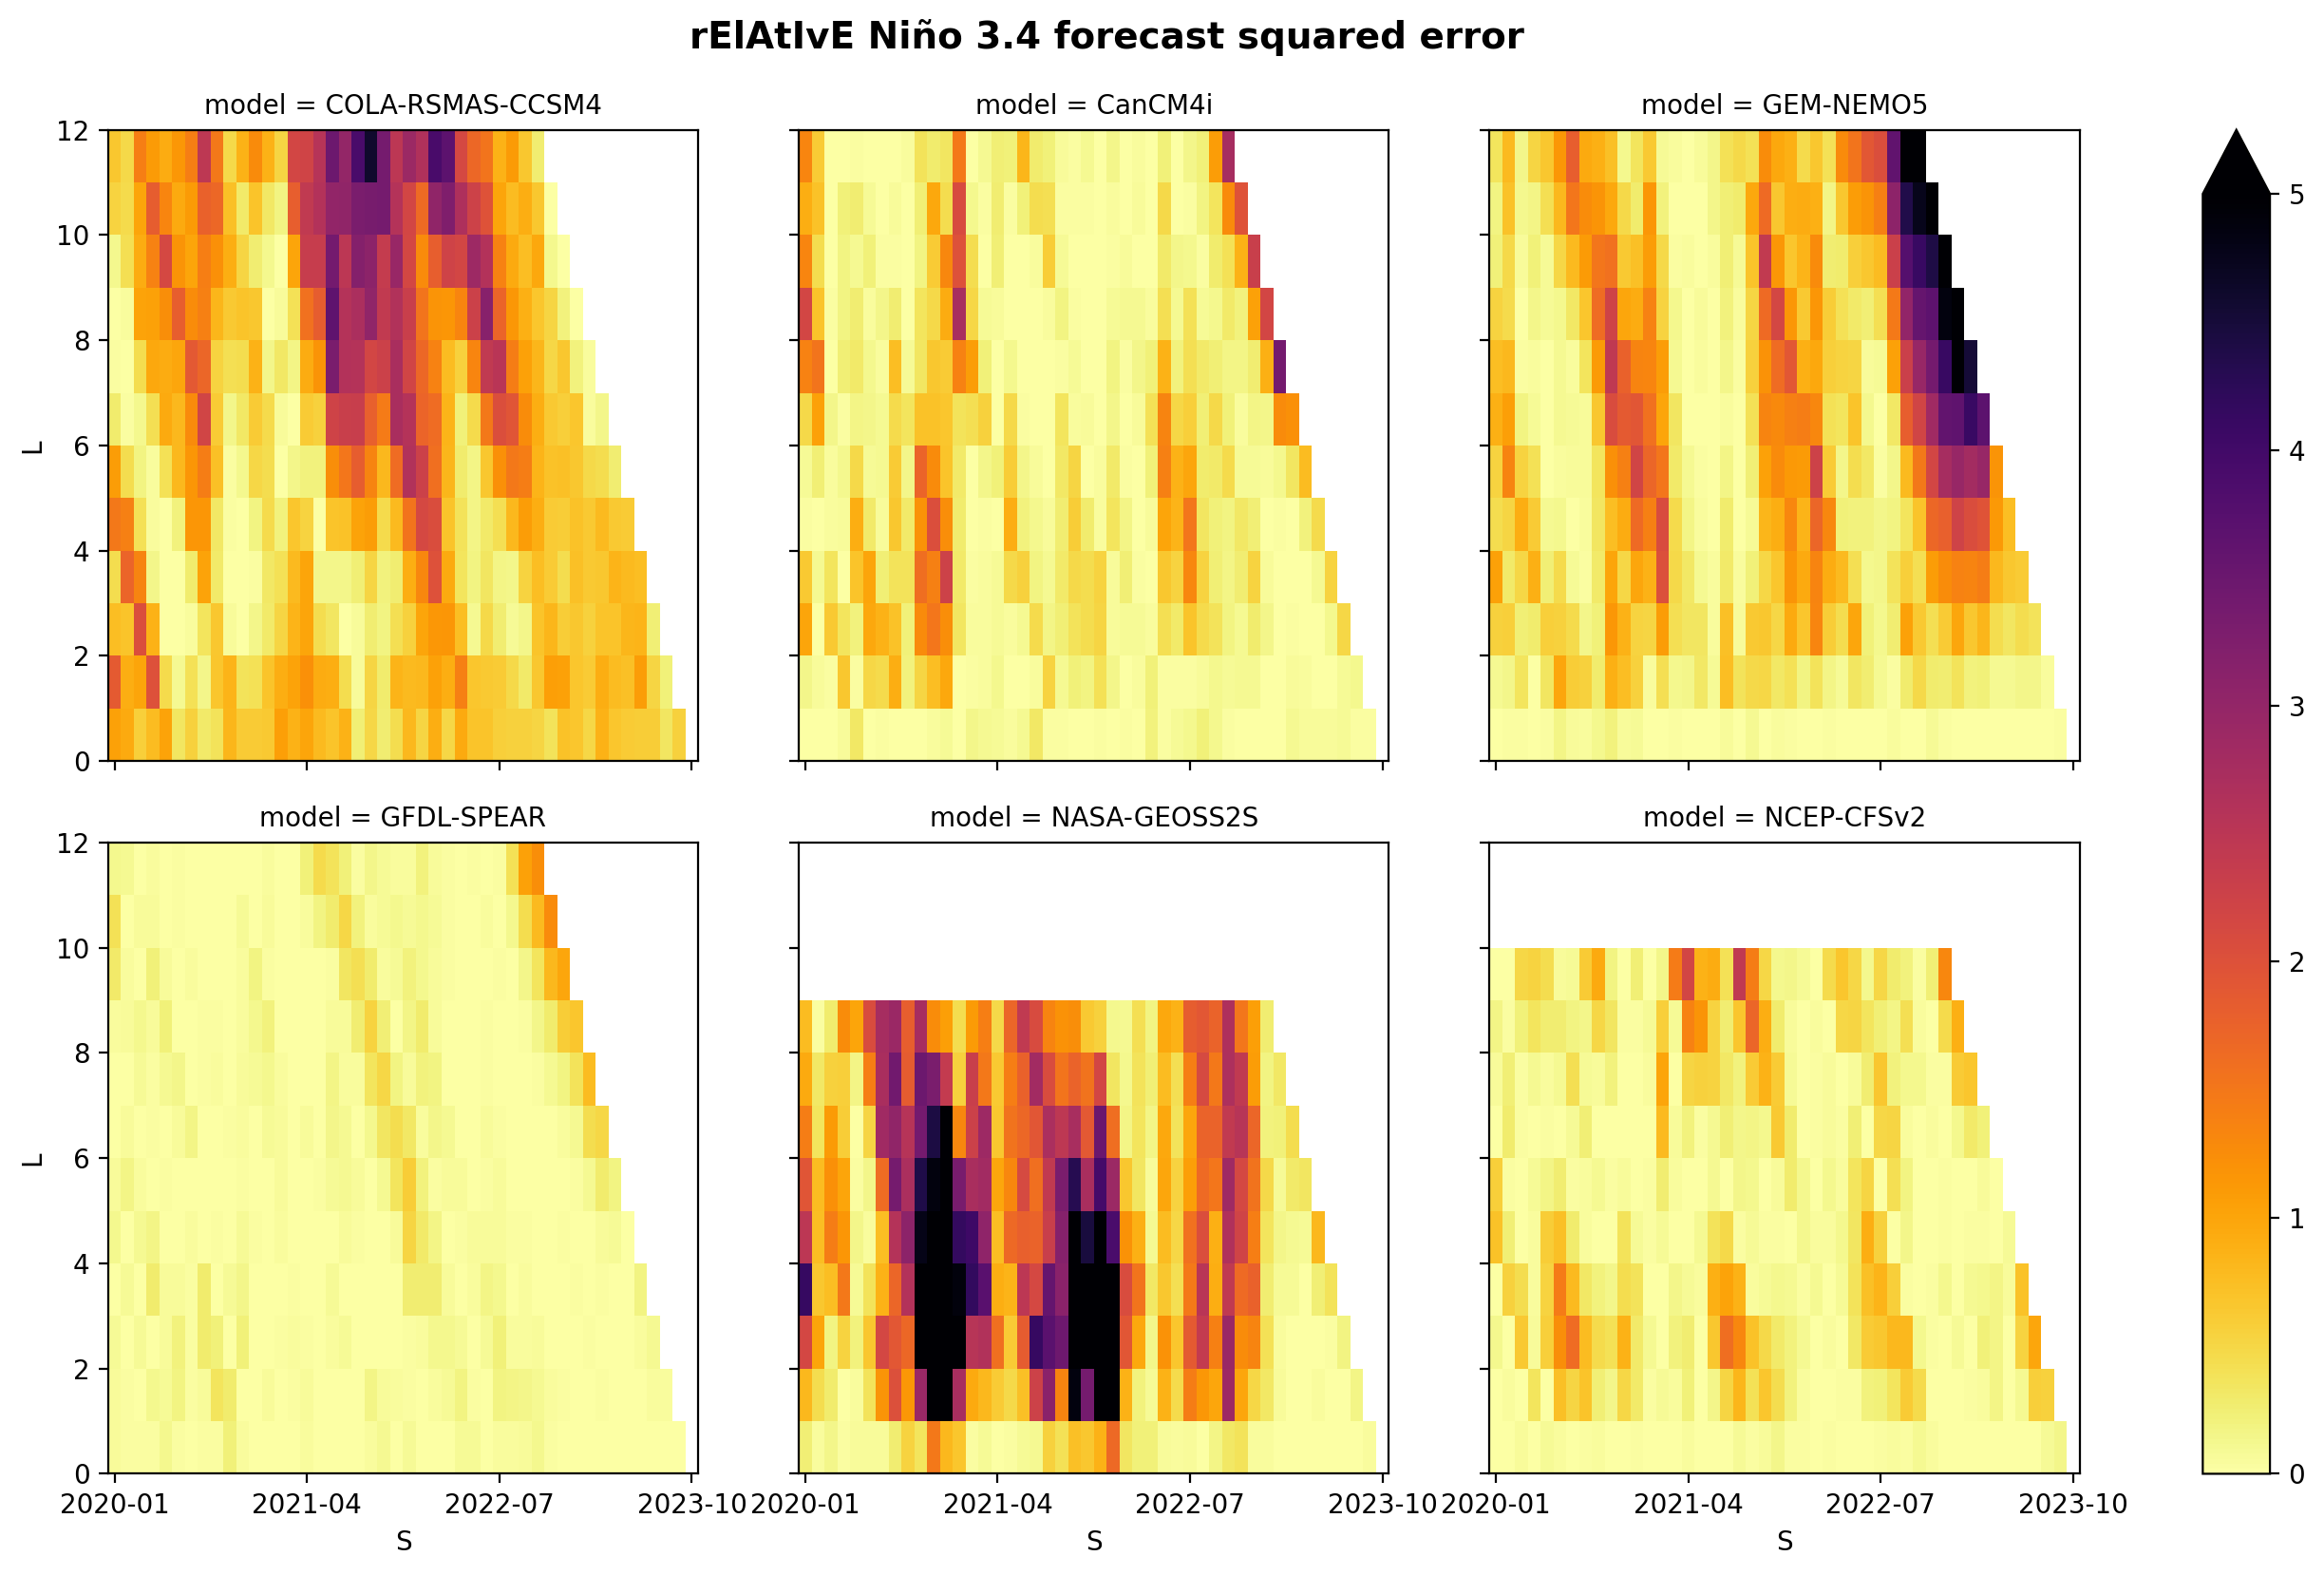

In [46]:
#Ensemble mean anomaly error
e = (ds.sst.mean('M') - ds.obs)**2
g = e.sel(S=slice('2020', None)).plot(col='model', col_wrap = 3, x='S', vmin=0, vmax=5, cmap='inferno_r', figsize=(14, 8));
fig = g.fig
fig.suptitle('rElAtIvE Niño 3.4 forecast squared error', x = 0.42, y=1.03, fontsize=14, fontweight='bold');
fig.set_facecolor("white")
plt.show()

## Bias

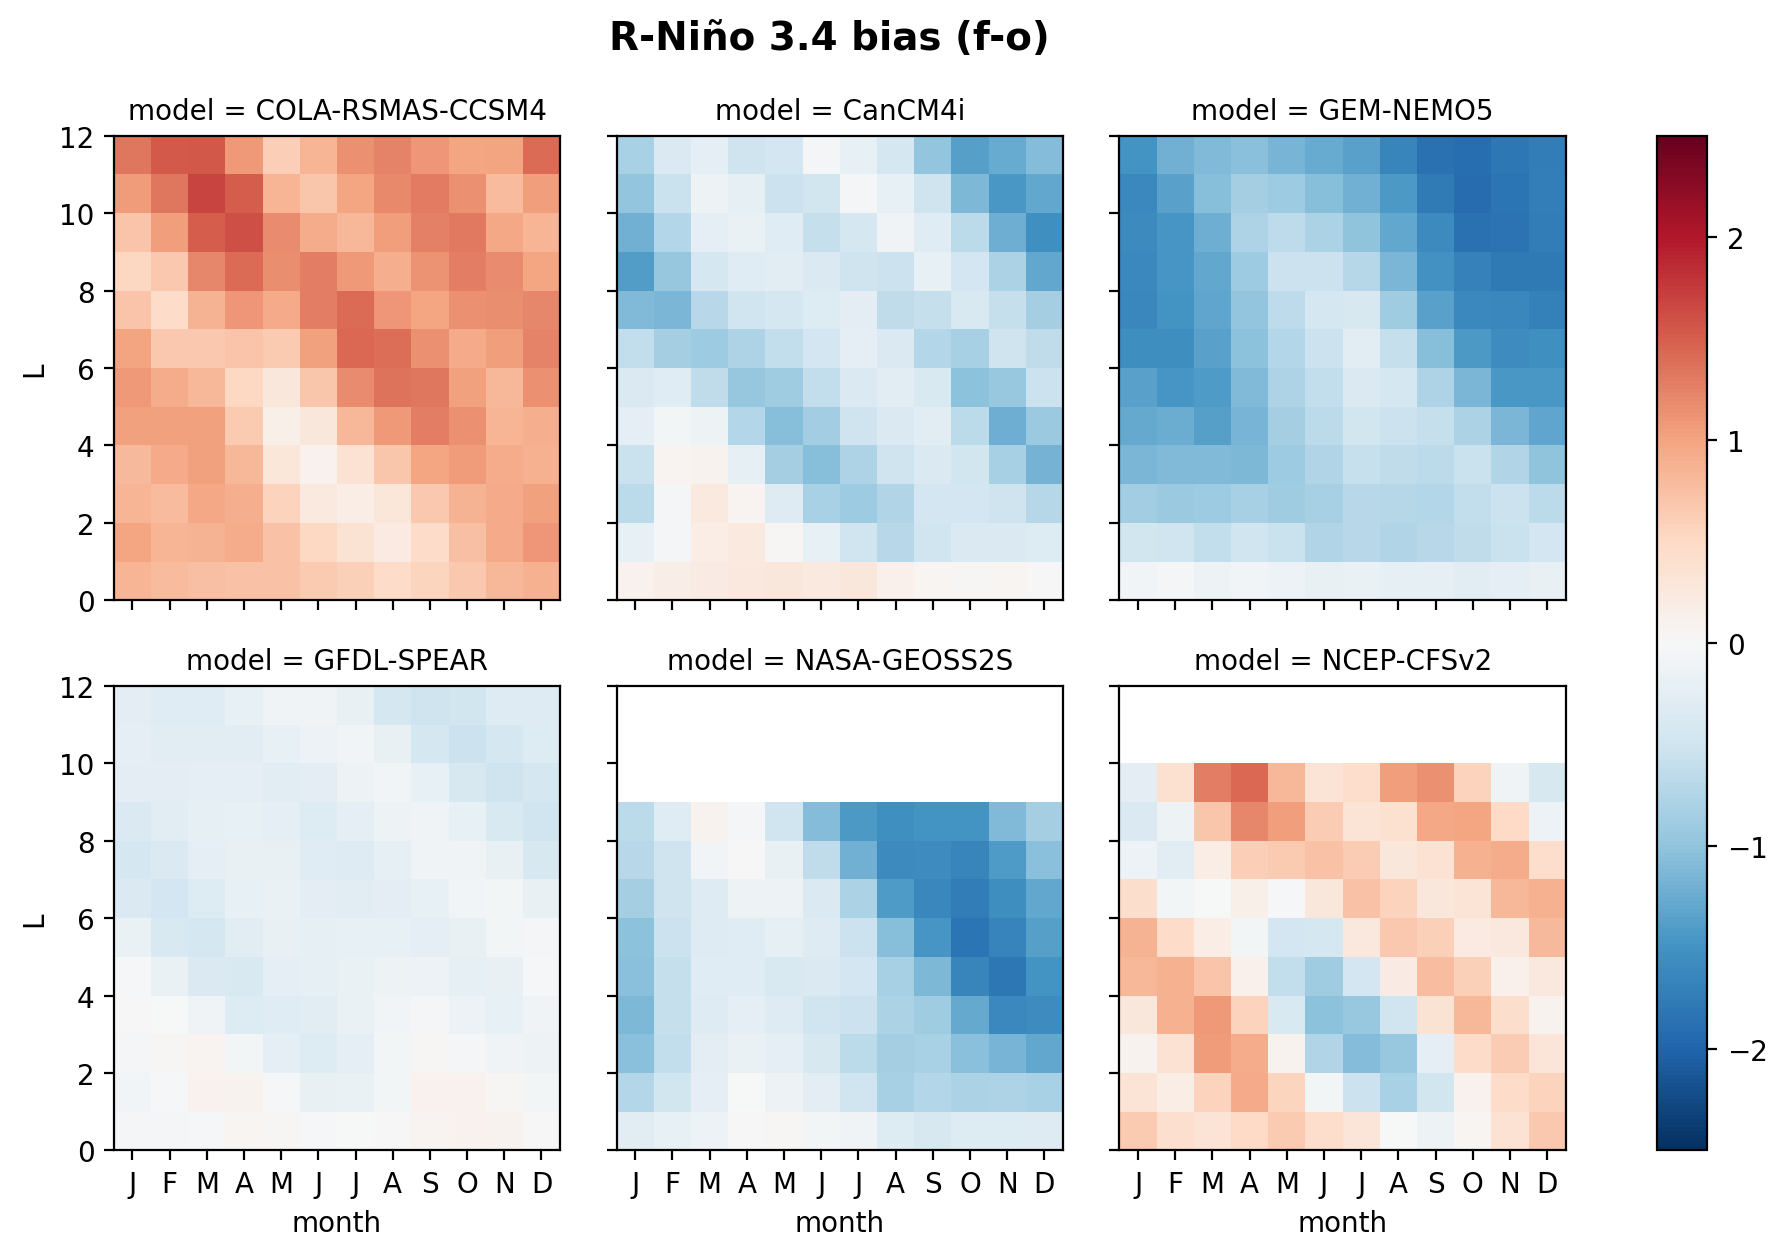

In [47]:
# Bias
bias = (ds.sst - ds.obs).groupby('S.month').mean(('M', 'S'))
bias.month.attrs['long_name'] = 'start month'
g = bias.plot(col='model', vmin = -2.5, col_wrap = 3, x='month')
plt.xticks(ds.L + 0.5, labels=m_str)
fig = g.fig
fig.suptitle('R-Niño 3.4 bias (f-o)', x = 0.42, y=1.04, fontsize=14, fontweight='bold');
fig.set_facecolor("white")
plt.show()

# Skill by lead

## 1. Correlation

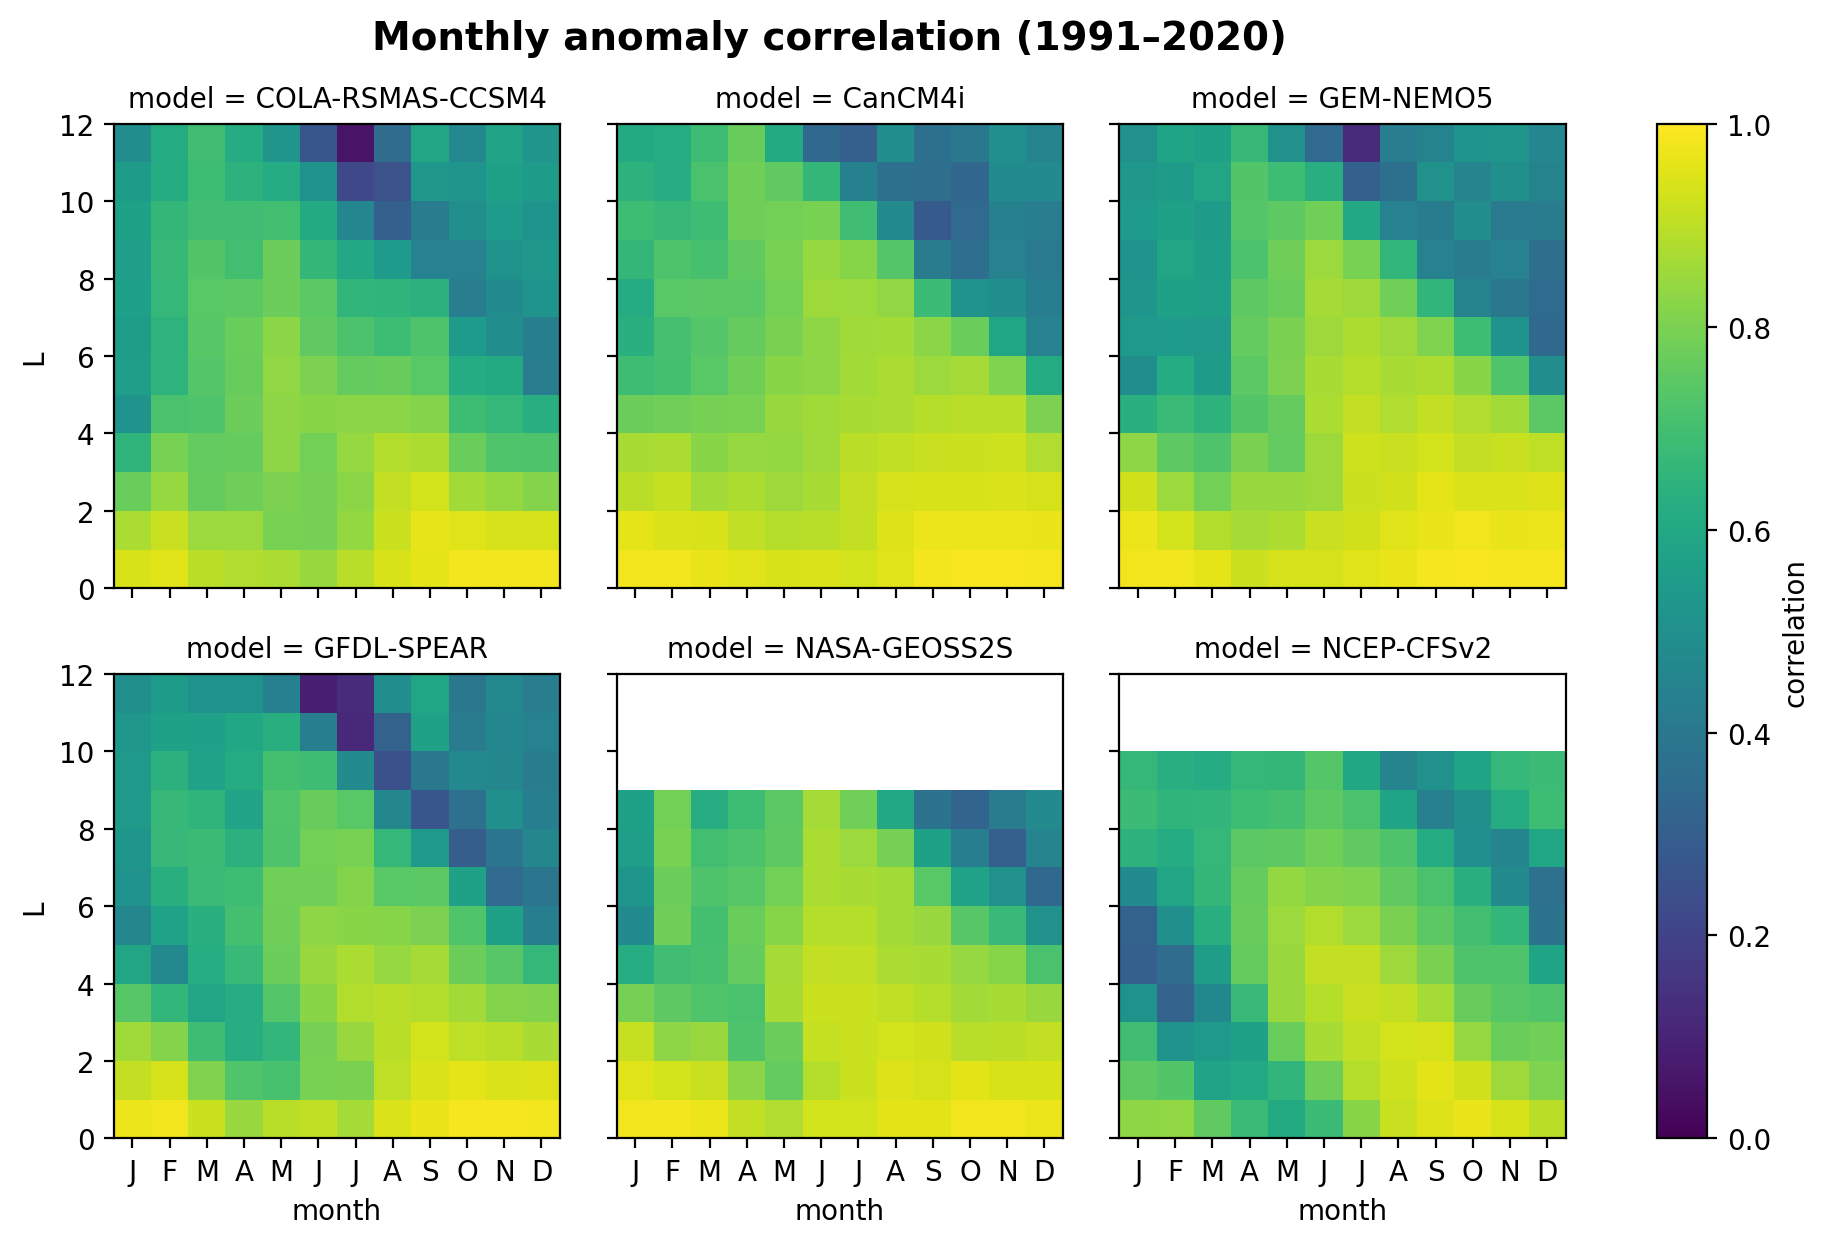

In [48]:
ac1 = ac_by_start(ds.ssta.mean('M').sel(S=slice('1991-01-01', '2020-12-01')), ds.obsa.sel(S=slice('1991-01-01', '2020-12-01')))
fg = ac1.plot(col='model', col_wrap = 3, x='month', vmin=0., vmax=1);
plt.xticks(np.arange(0, 12) + 1, labels=m_str)
fig = fg.fig
fig.suptitle('Monthly anomaly correlation (1991–2020)', x = 0.42, y=1.03, fontsize=14, fontweight='bold');
fig.set_facecolor("white")
plt.show()

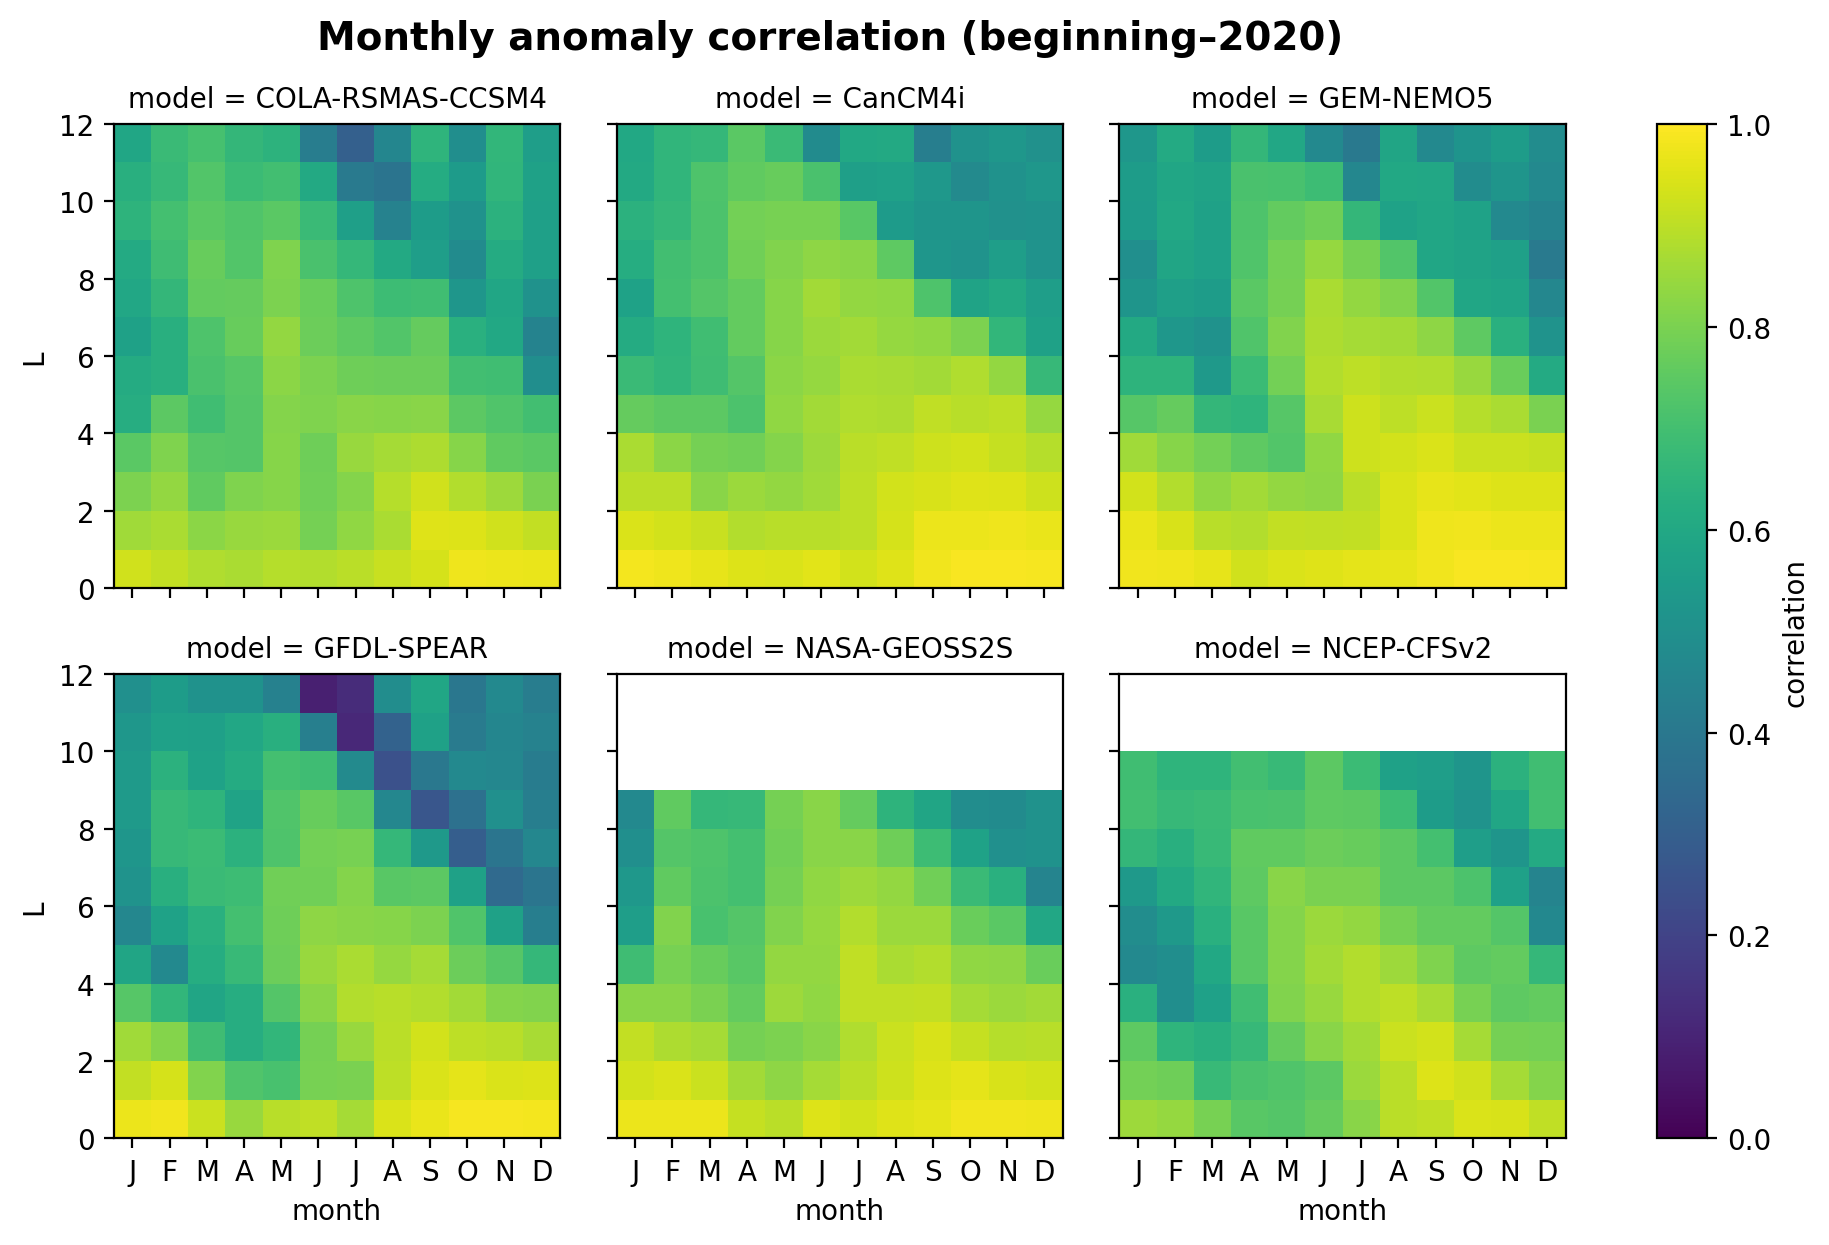

In [49]:
ac2 = ac_by_start(ds.ssta.mean('M').sel(S=slice(None, '2020-12-01')), ds.obsa.sel(S=slice(None, '2020-12-01')))
fg = ac2.plot(col='model', col_wrap = 3, x='month', vmin=0., vmax=1);
plt.xticks(np.arange(0, 12) + 1, labels=m_str)
fig = fg.fig
fig.suptitle('Monthly anomaly correlation (beginning–2020)', x = 0.42, y=1.03, fontsize=14, fontweight='bold');
fig.set_facecolor("white")
plt.show()

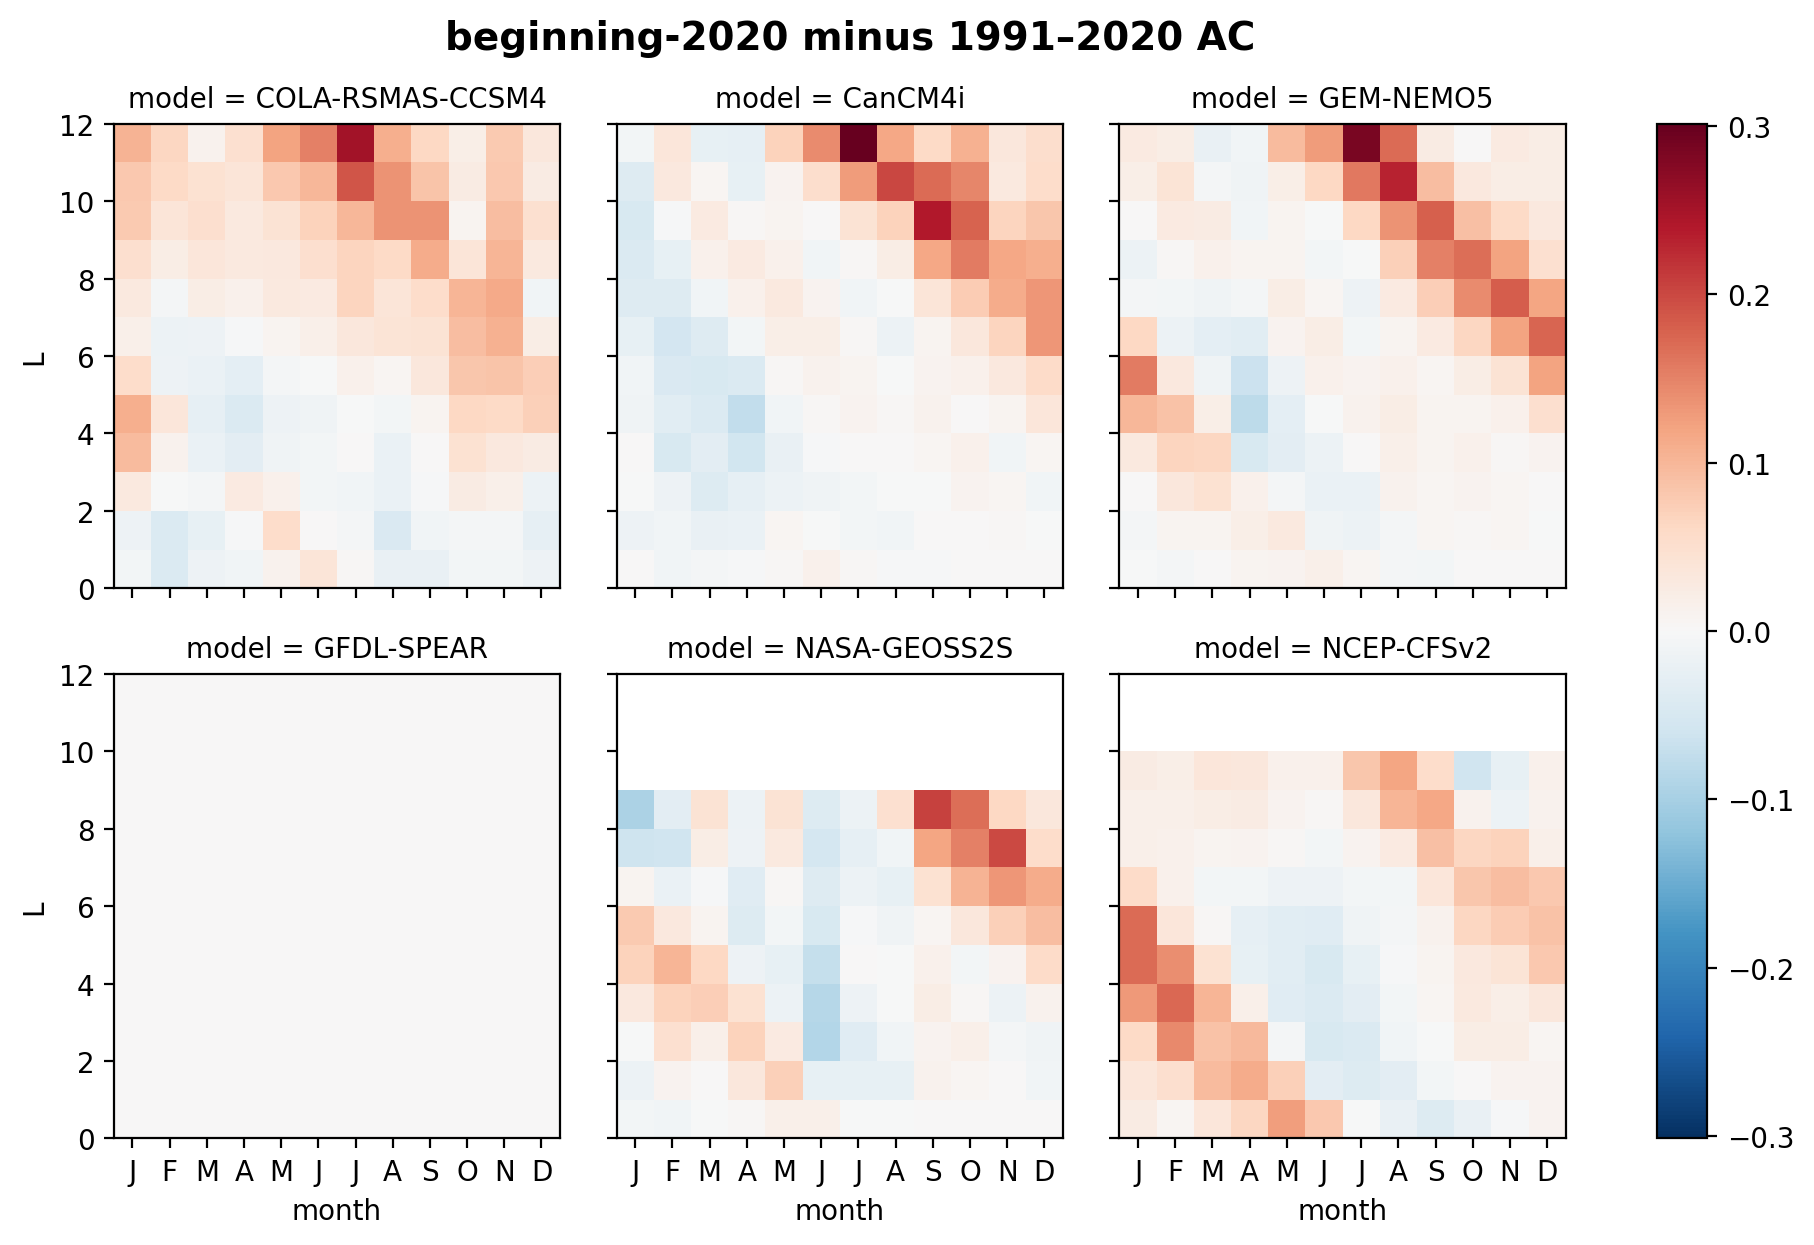

In [50]:
fg = (ac2 - ac1).plot(col='model', col_wrap = 3, x='month');
plt.xticks(np.arange(0, 12) + 1, labels=m_str)
fig = fg.fig
fig.suptitle('beginning-2020 minus 1991–2020 AC', x=0.43, y=1.03, fontsize=14, fontweight='bold');
fig.set_facecolor("white")

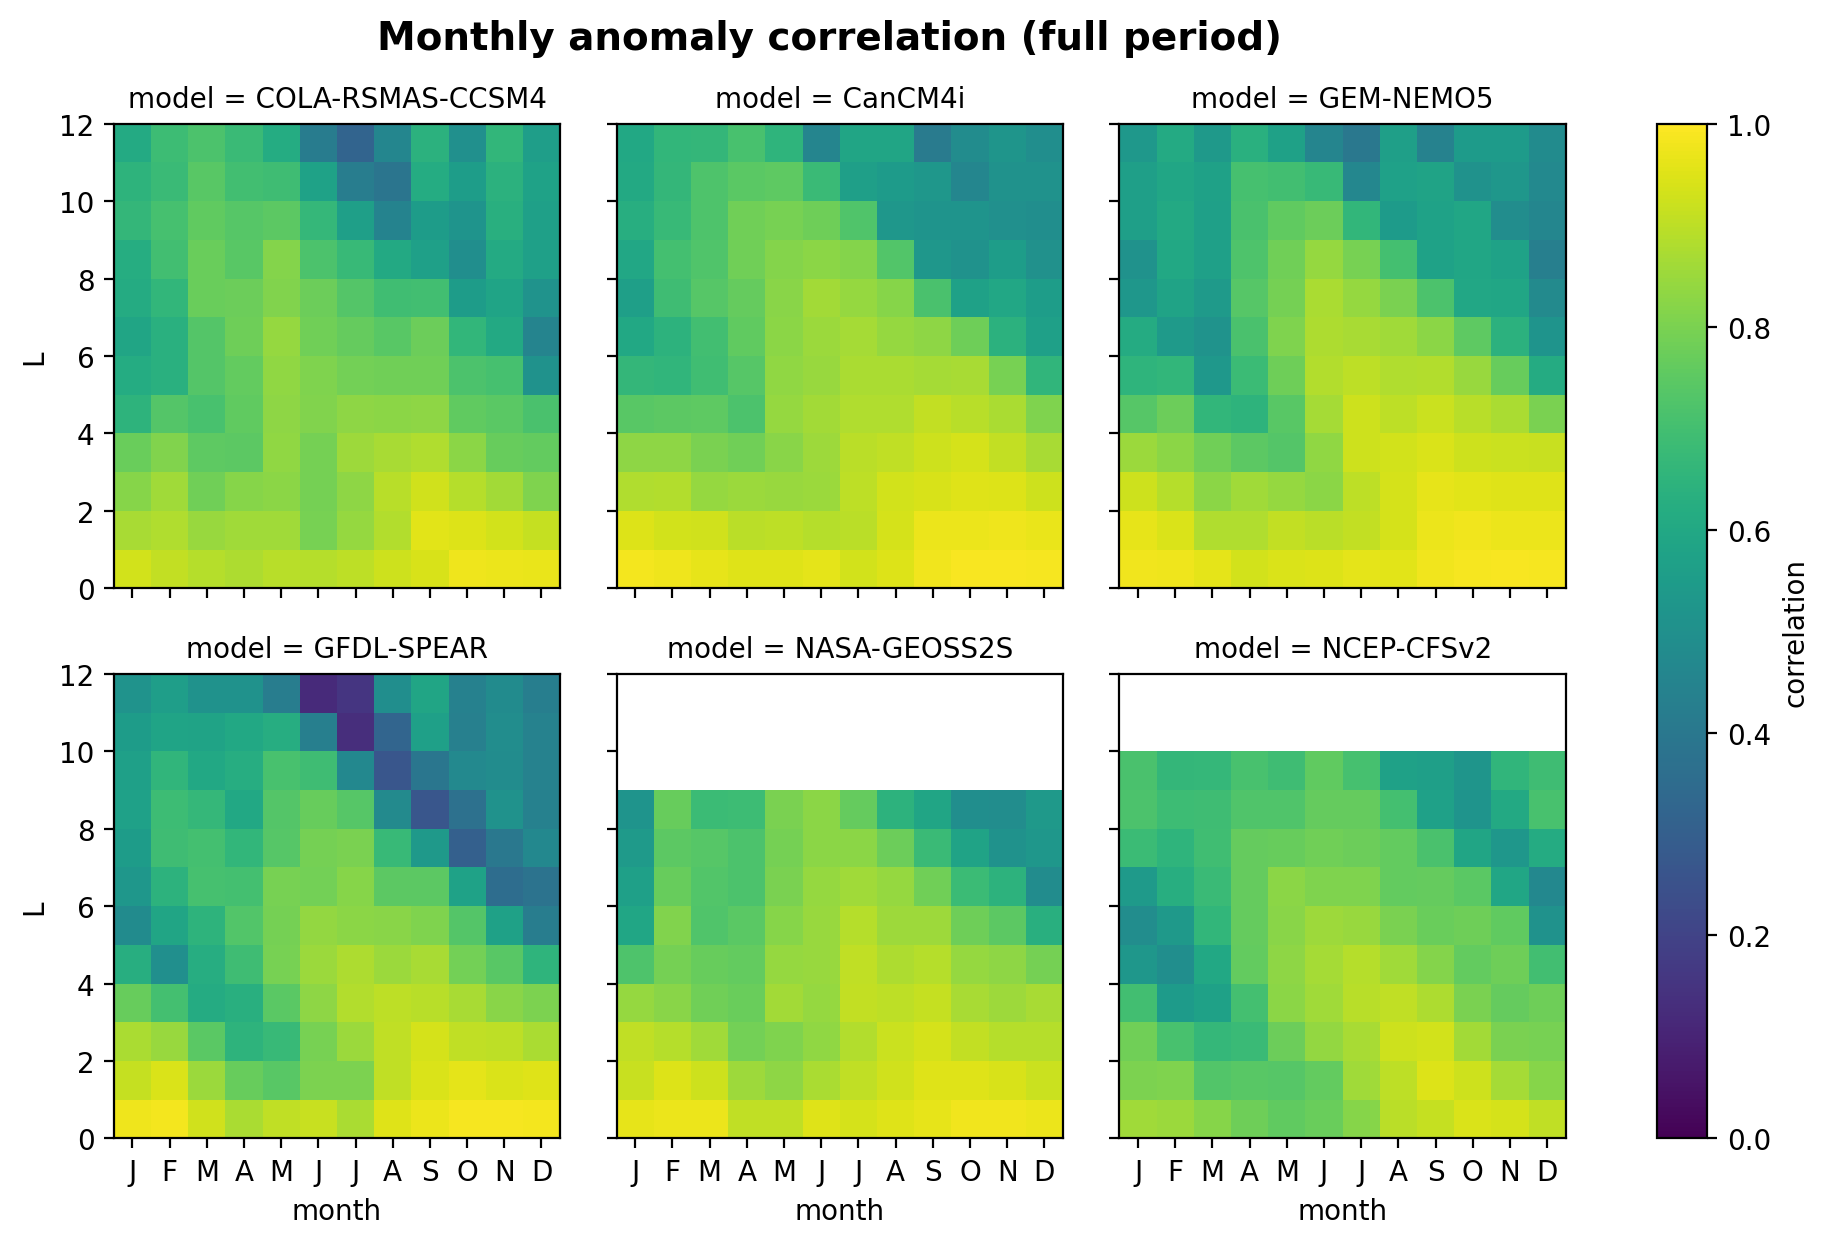

In [51]:
#ac = ac_by_start(ds.ssta.mean('M').rolling(L=3).mean(), ds.obsa.rolling(L=3).mean())
ac = ac_by_start(ds.ssta.mean('M'), ds.obsa)
fg = ac.plot(col='model', col_wrap = 3, x='month', vmin=0., vmax=1)
plt.xticks(np.arange(0, 12) + 1, labels=m_str)
fig = fg.fig
fig.suptitle('Monthly anomaly correlation (full period)', x = 0.42, y=1.03, fontsize=14, fontweight='bold');
fig.set_facecolor("white")
plt.show()

In [52]:
ac_target = ac.copy()
ac_target.month.attrs['long_name'] = 'target month'
for ii in range(0, 12):
    #ac_target[:, :, ii] = np.roll(ac[:, :, ii].values, ii)
    ac_target.loc[dict(L=(ii+0.5))] = ac_target.loc[dict(L=(ii+0.5))].roll(month=ii, roll_coords=False)

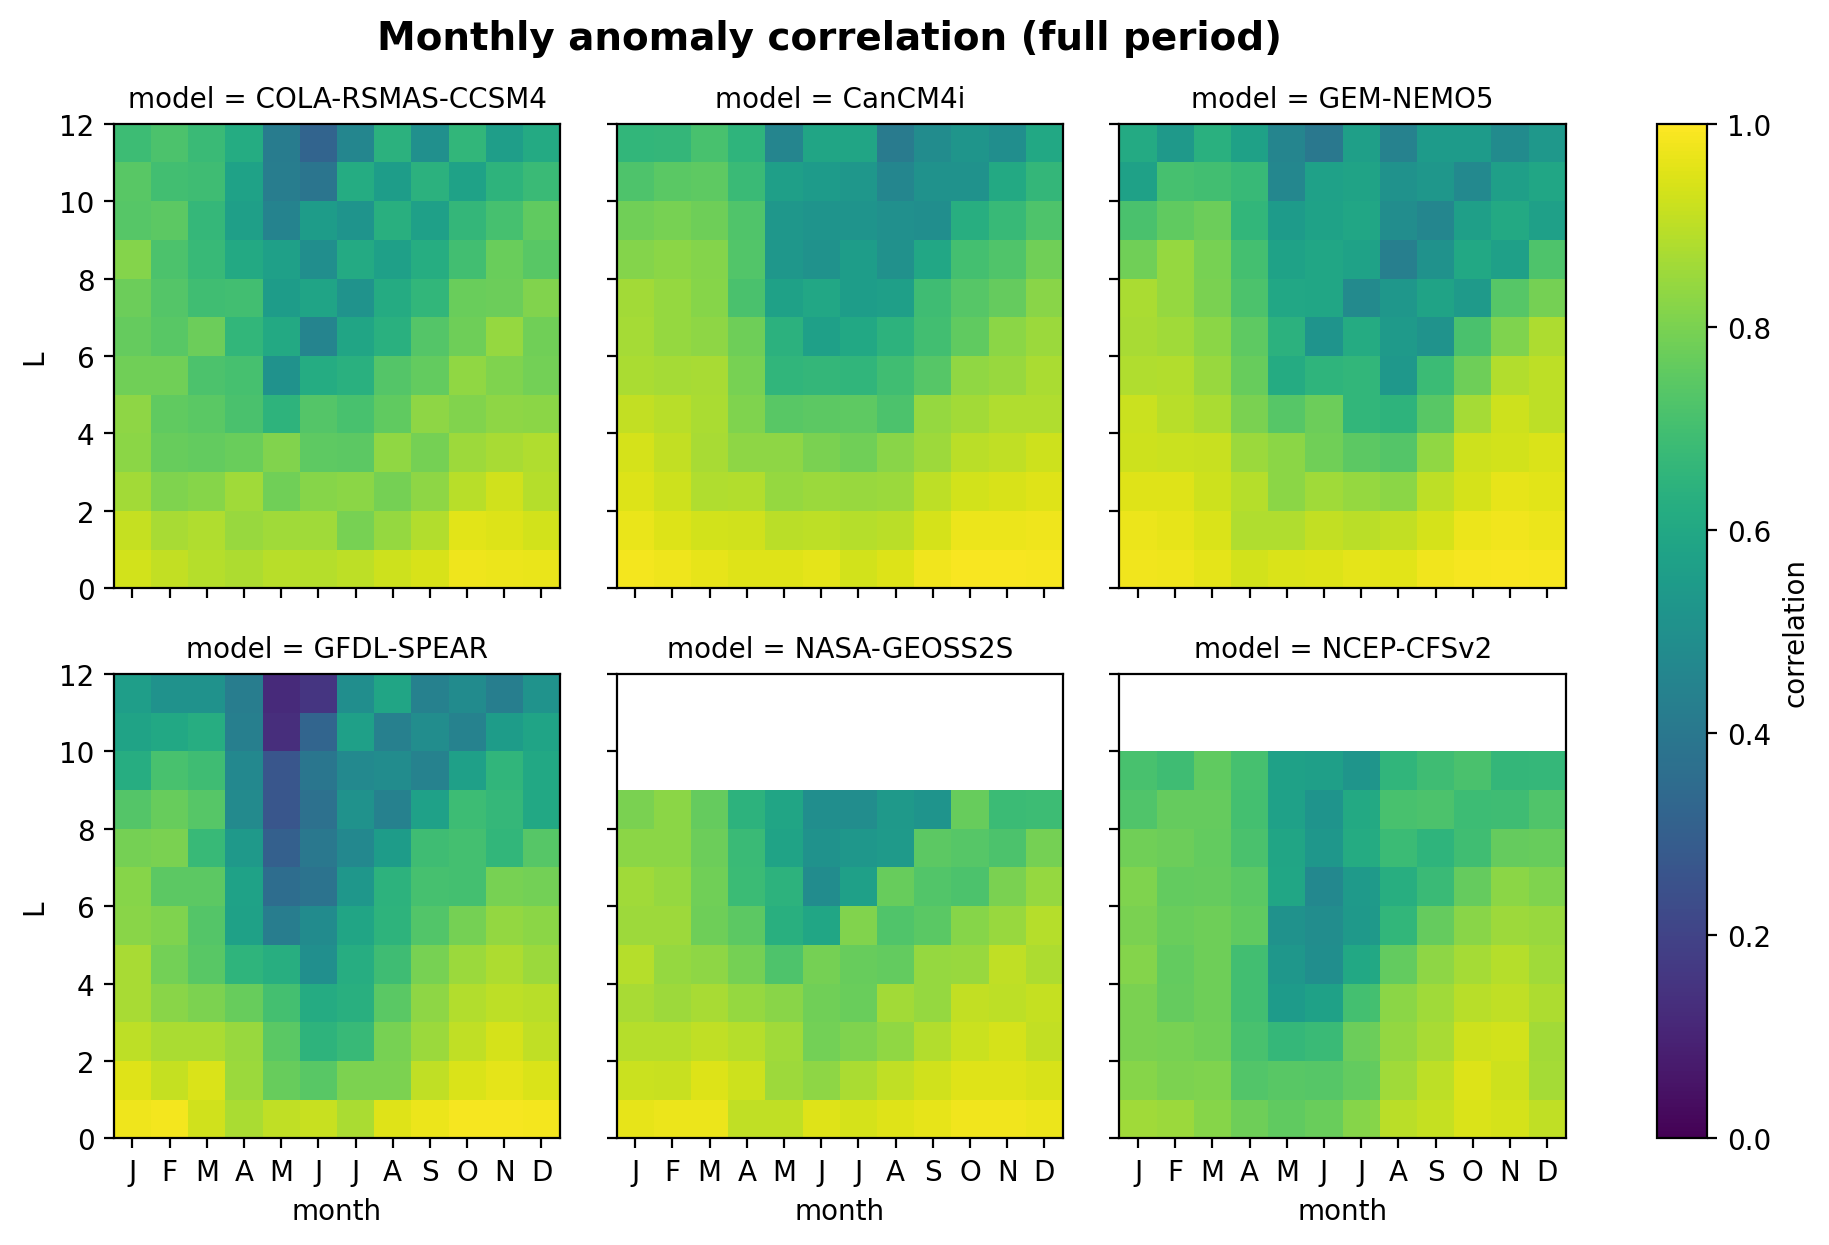

In [53]:
fg = ac_target.plot(col='model', col_wrap = 3, x='month', vmin=0., vmax=1);
plt.xticks(np.arange(0, 12) + 1, labels=m_str)
fig = fg.fig
fig.suptitle('Monthly anomaly correlation (full period)', x = 0.42, y=1.03, fontsize=14, fontweight='bold');
fig.set_facecolor("white")
plt.show()

## 2. MSESS

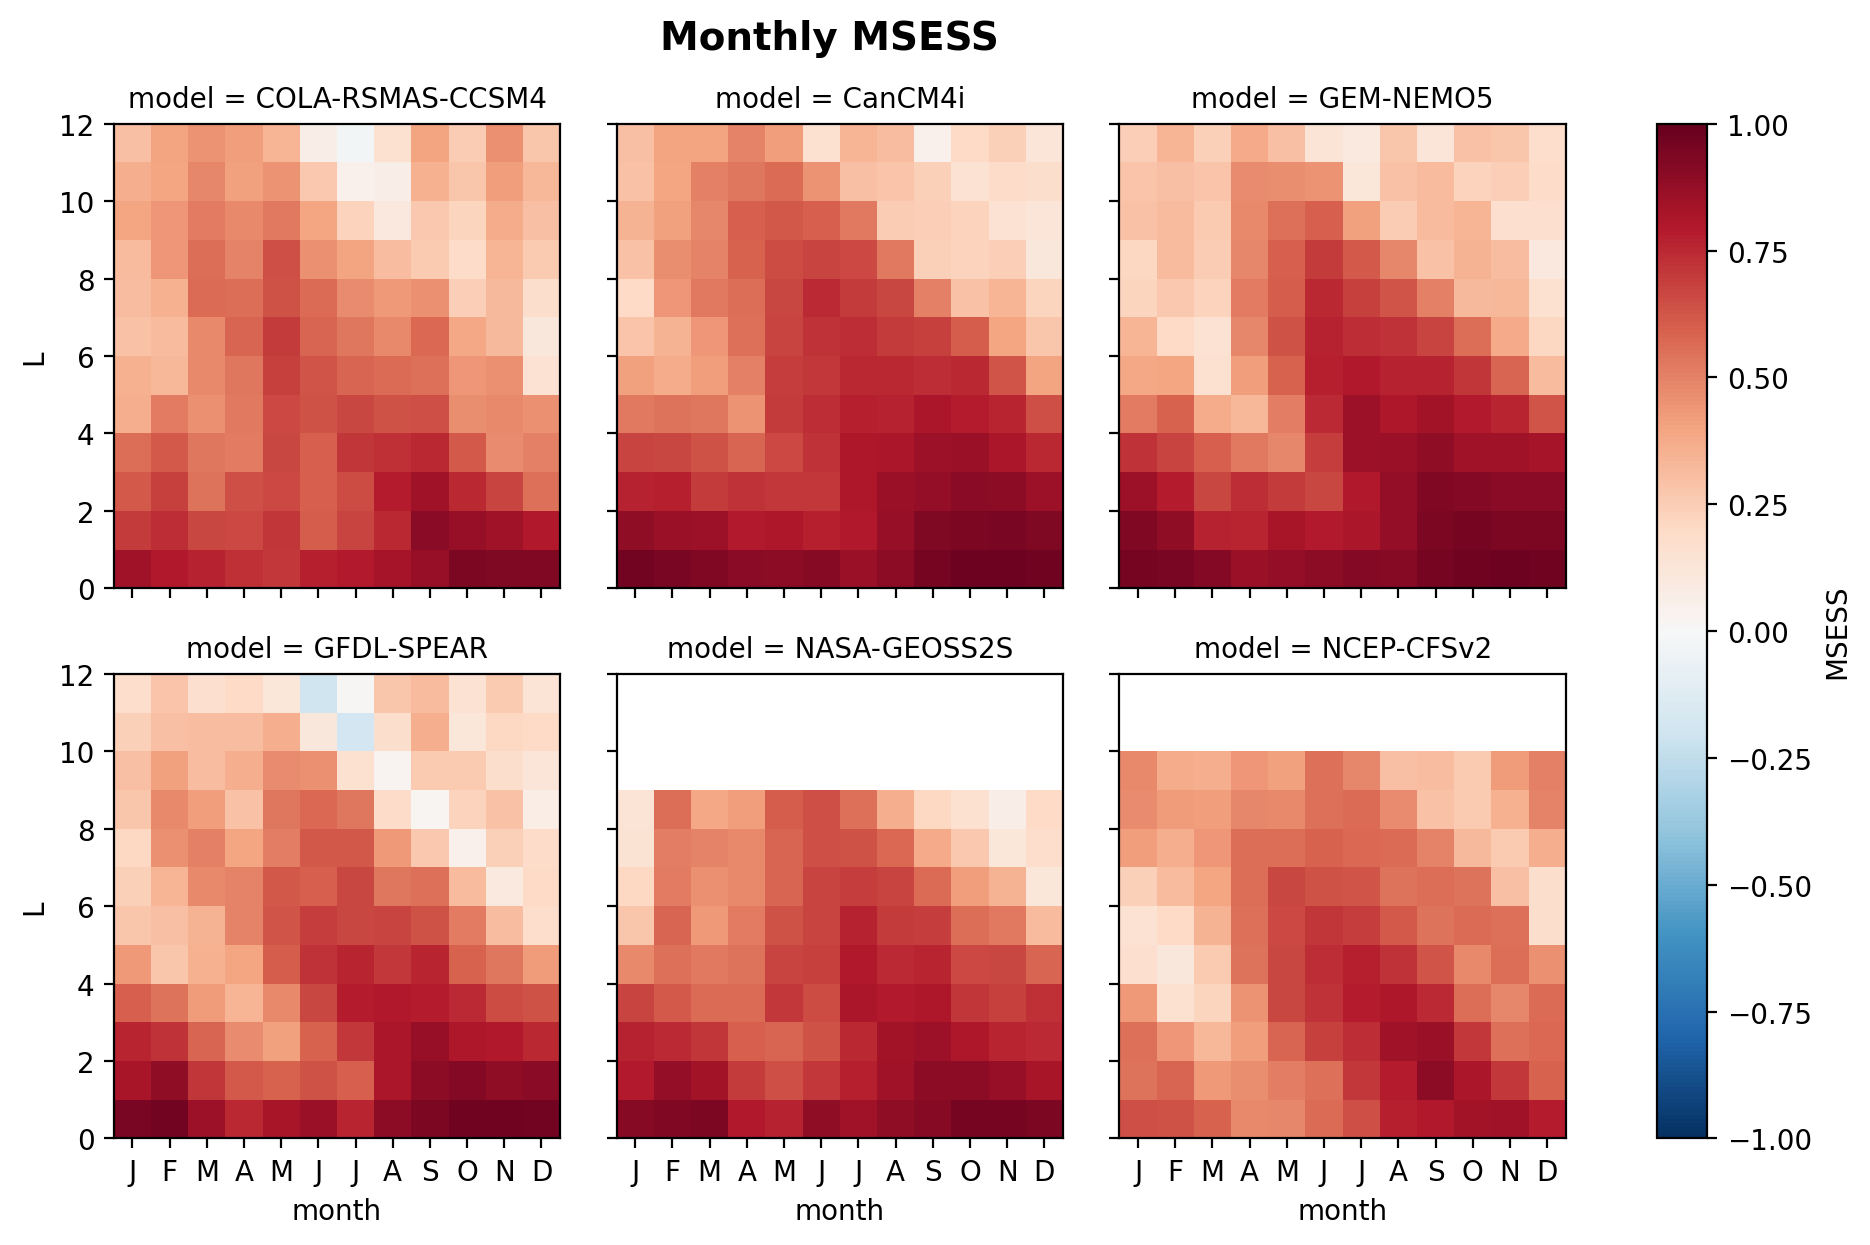

In [54]:
msess = msess_by_start(ds.ssta.mean('M'), ds.obsa)
fg = msess.plot(col='model', col_wrap = 3, x='month', vmax=1);
plt.xticks(np.arange(0, 12) + 1, labels=m_str)
fig = fg.fig
fig.suptitle('Monthly MSESS', x = 0.42, y=1.03, fontsize=14, fontweight='bold');
fig.set_facecolor("white")
plt.show()

In [55]:
msess_target = msess.copy()
msess_target.month.attrs['long_name'] = 'target month'
for ii in range(0, 12):
    msess_target.loc[dict(L=(ii+0.5))] = msess_target.loc[dict(L=(ii+0.5))].roll(month=ii, roll_coords=False)

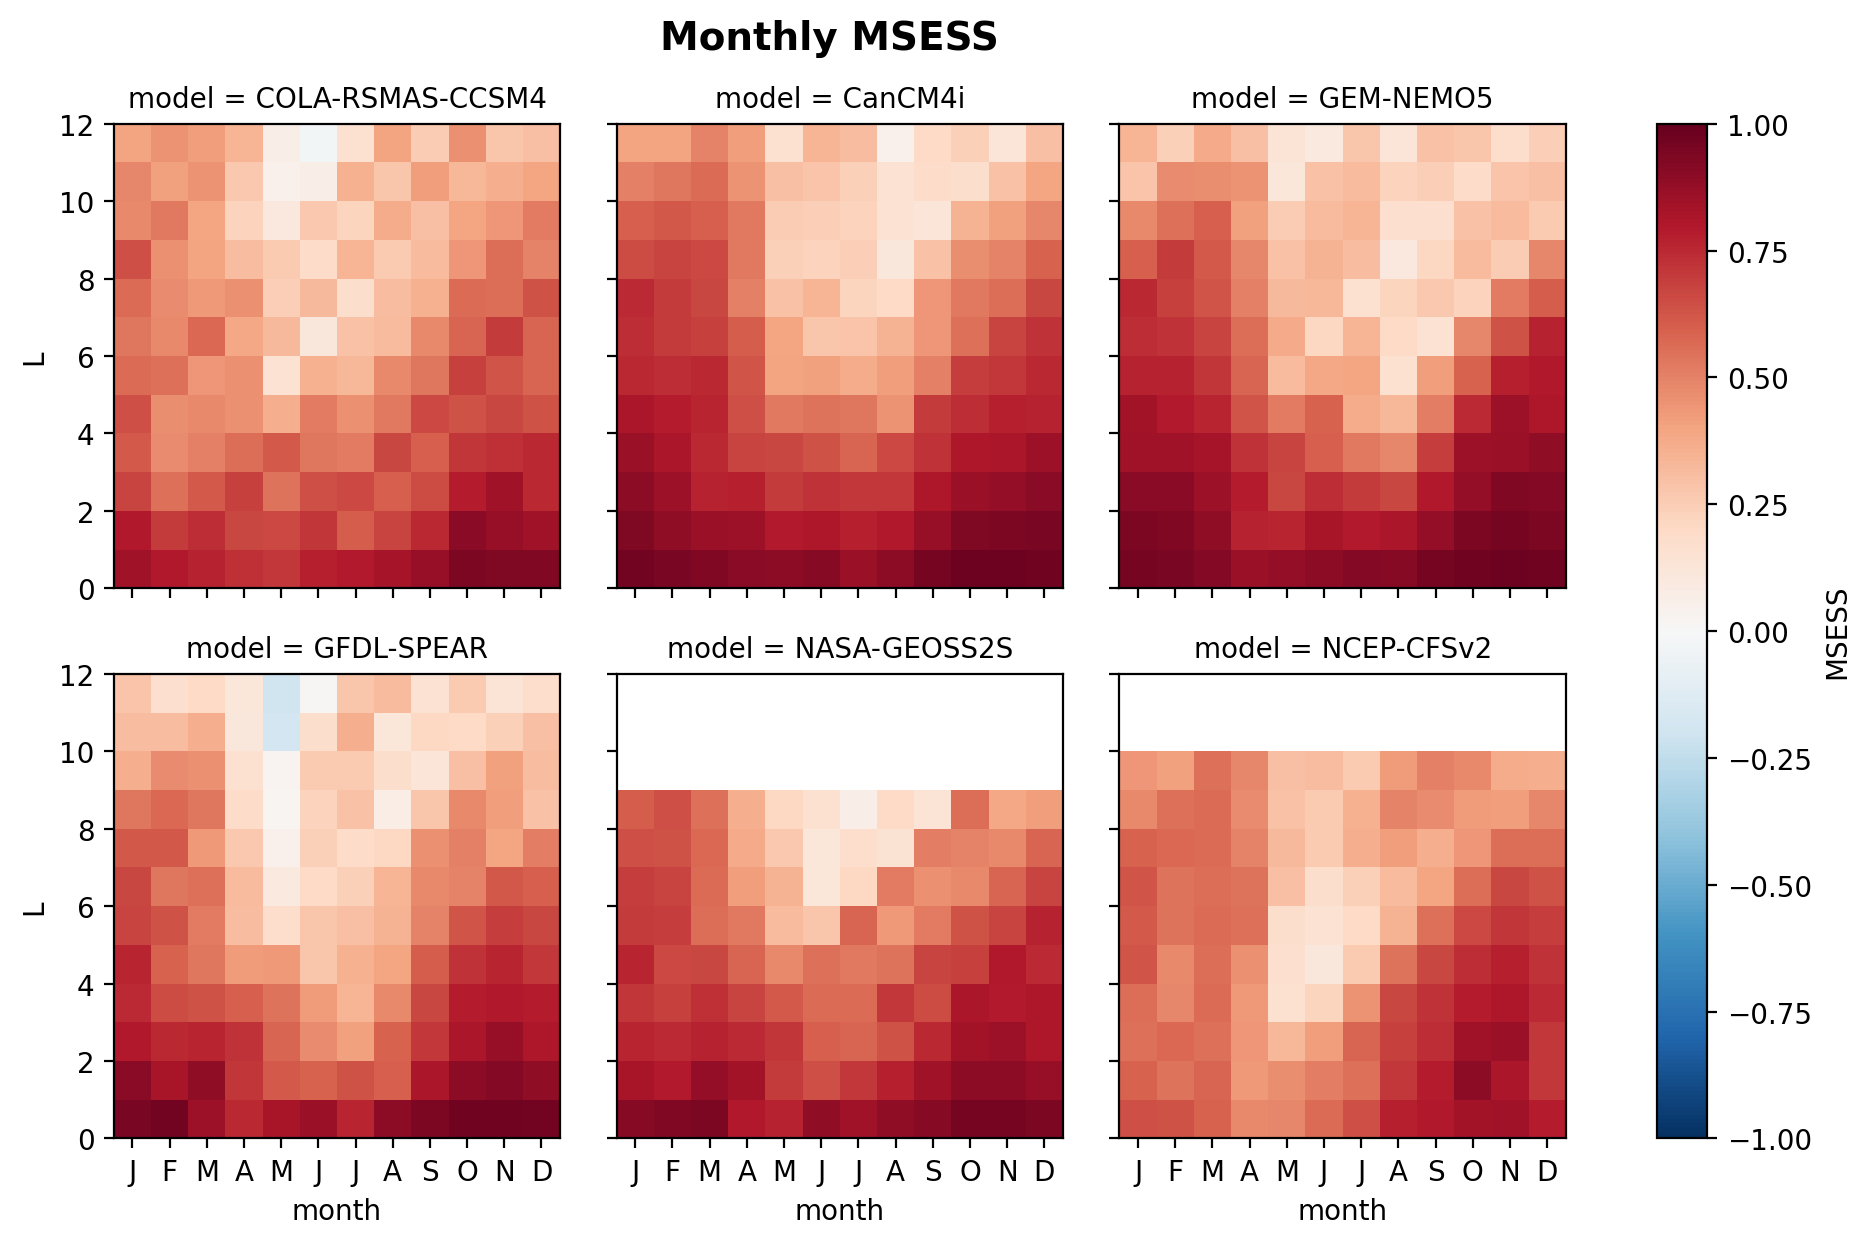

In [56]:
fg = msess_target.plot(col='model', col_wrap = 3, x='month', vmax=1);
plt.xticks(np.arange(0, 12) + 1, labels=m_str)
fig = fg.fig
fig.suptitle('Monthly MSESS', x = 0.42, y=1.03, fontsize=14, fontweight='bold');
fig.set_facecolor("white")
plt.show()

# Plume

## Most recent forecast 

In [57]:
# ds.sst.loc[dict(model='NASA-GEOSS2S', S='2021-08-01 00:00:00',L=slice(1, None))].plot();

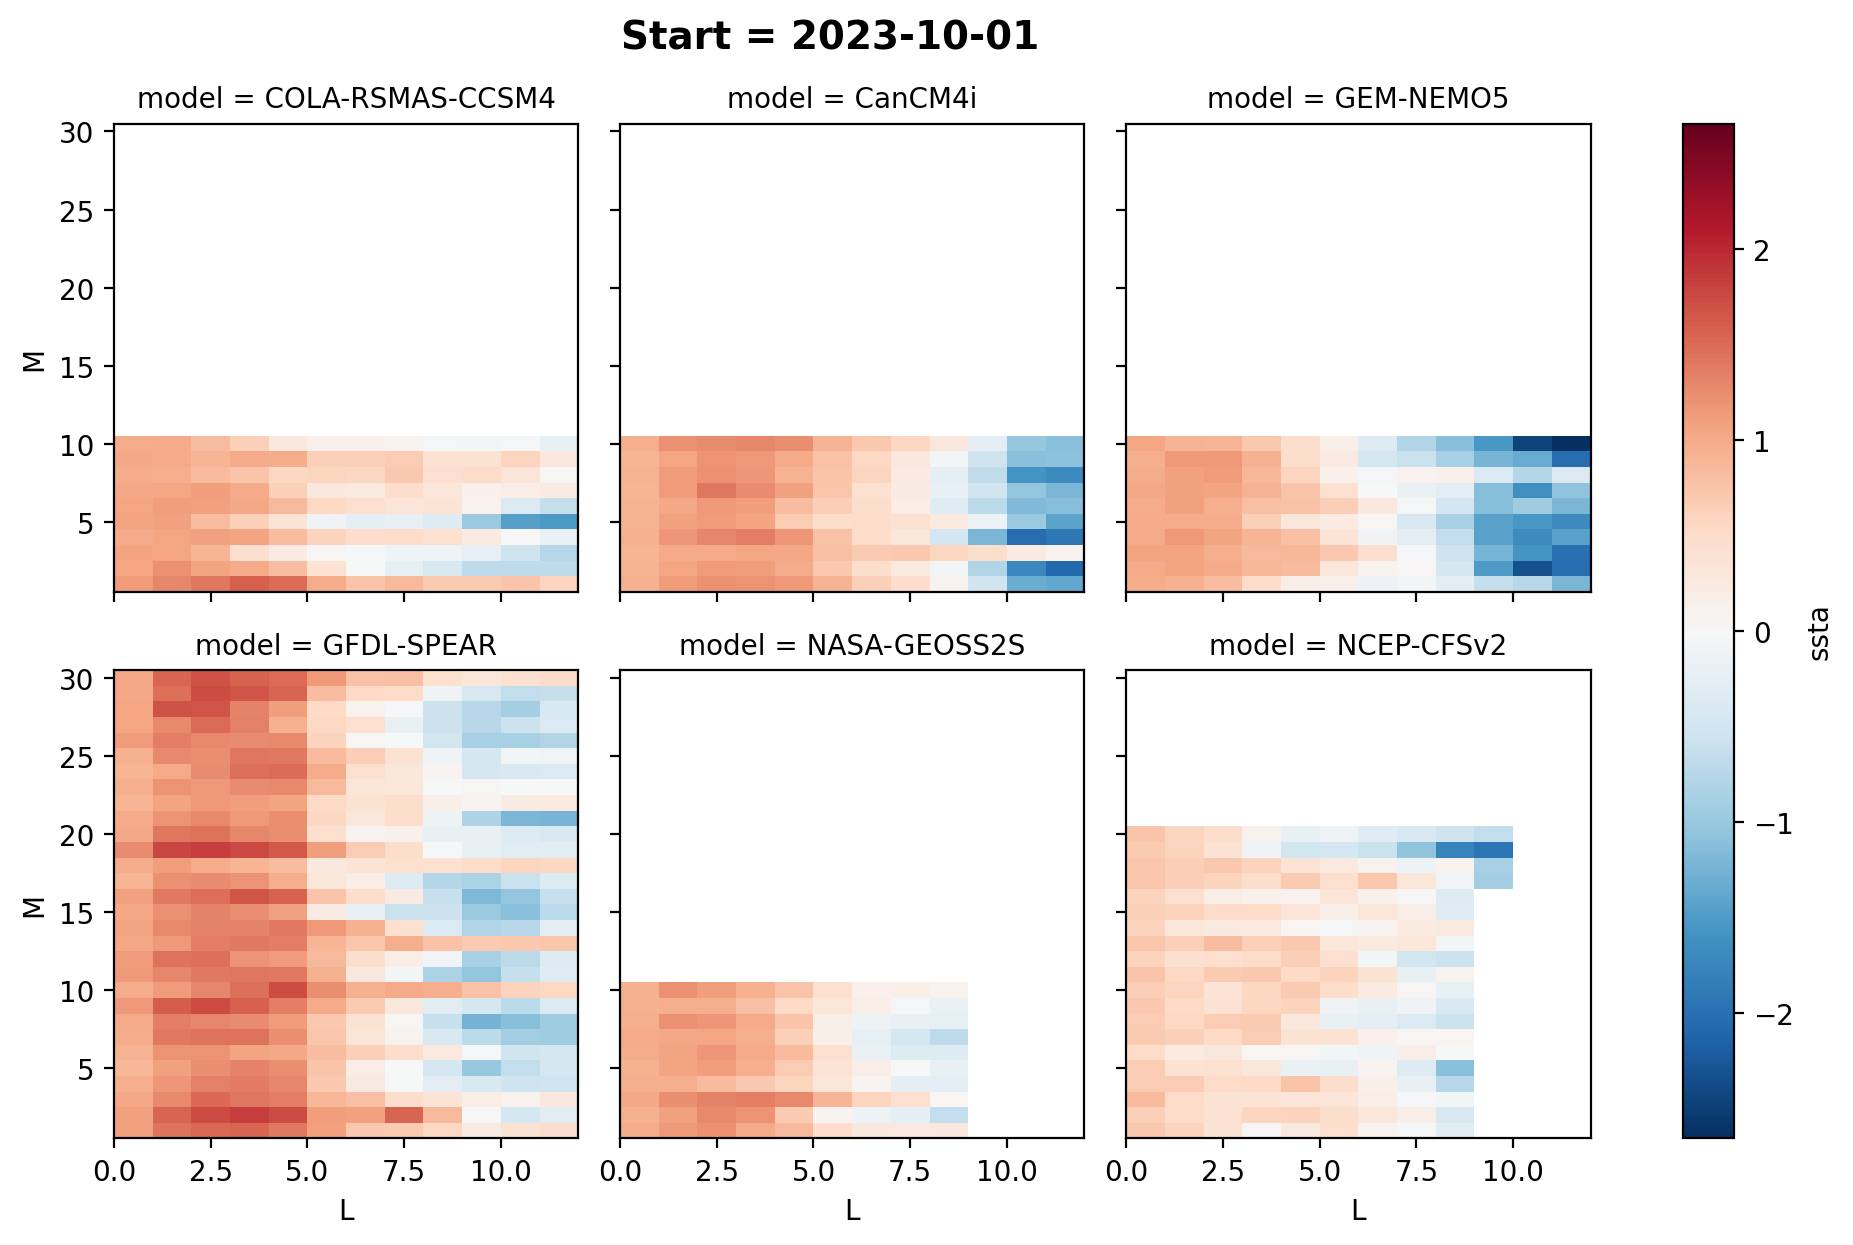

In [58]:
# Most recent forecast
fg = ds.ssta.isel(S=-1).plot(col='model', col_wrap = 3);
fig = fg.fig
fig.set_facecolor("white")
fig.suptitle('Start = ' + str(ds.S[-1].values)[:10], x = 0.42, y=1.03, fontsize=14, fontweight='bold');

In [59]:
#convert from cftime to regular time
start = ds.indexes['S'].to_datetimeindex()

/var/folders/vh/dq0bg6h94bg8yn3bvm6wvr64000_qs/T/ipykernel_11118/2150960690.py:2: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, '360_day', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  start = ds.indexes['S'].to_datetimeindex()


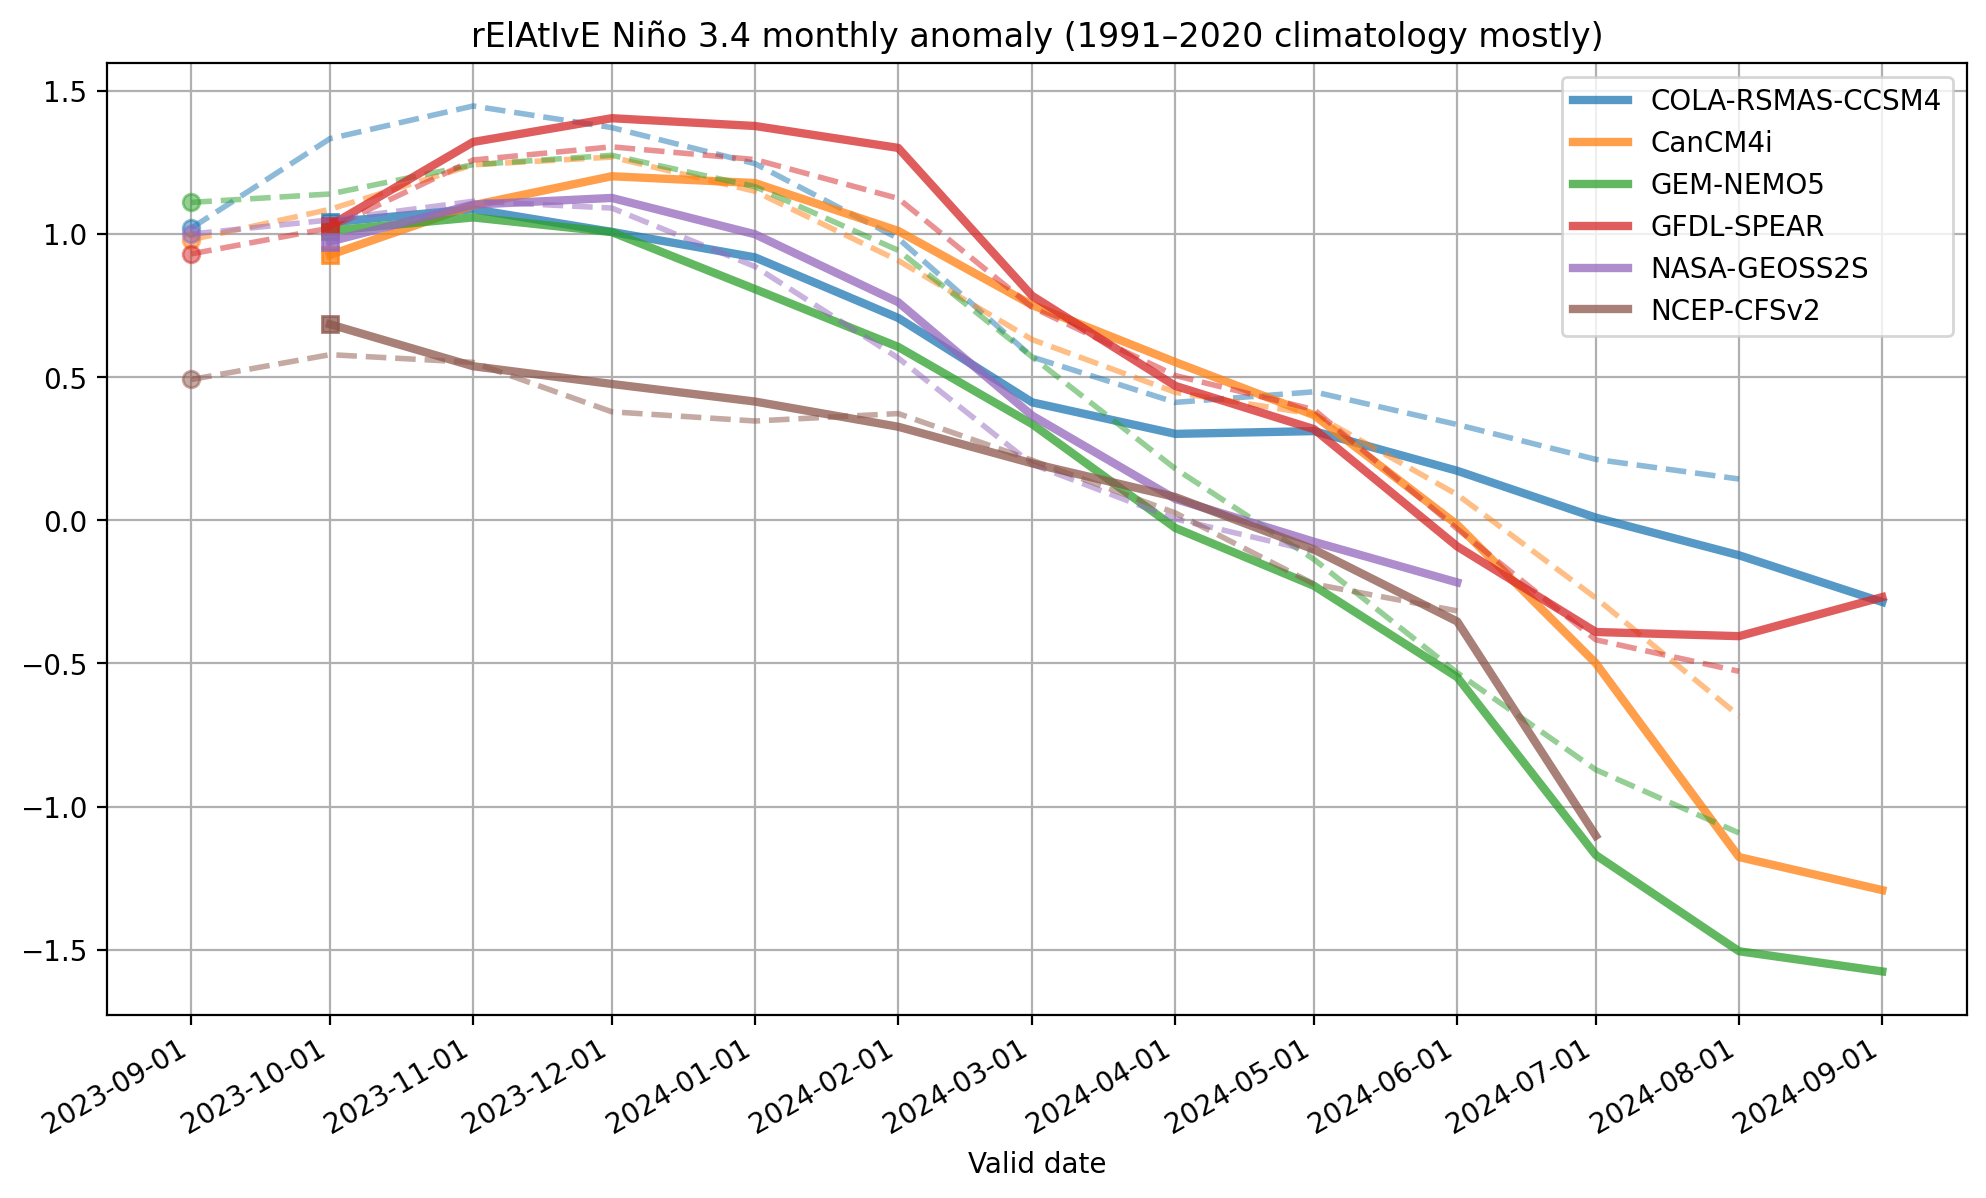

In [60]:
avail = np.where(~np.isnan(ds.ssta.isel(S=-1).isel(L=0).mean('M')))

fig,ax = plt.subplots(figsize=(12, 7))
for im in avail[0]:
    #last month
    leads = pd.date_range(start[-2], periods=12, freq="MS")
    ax.plot(leads, ds.ssta.isel(S=-2).mean('M').T[:, im], '--', lw=2, color=colors[im], alpha=0.5)
    ax.plot(leads[0], ds.ssta.isel(S=-2).mean('M').T[0, im], 'o', lw=2, color=colors[im], alpha=0.5)


    #this month
    leads = pd.date_range(start[-1], periods=12, freq="MS")
    ax.plot(leads, ds.ssta.isel(S=-1).mean('M').T[:, im], lw=3, color=colors[im], label=ds.model.values[im], alpha=0.75)
    ax.plot(leads[0], ds.ssta.isel(S=-1).mean('M').T[0, im], 's', lw=3, color=colors[im], alpha=0.75)

ax.set_xticks(pd.date_range(start[-2], periods=13, freq="MS"))
ax.set_xlabel('Valid date')
ax.set_title('rElAtIvE Niño 3.4 monthly anomaly (1991–2020 climatology mostly)')
fig.autofmt_xdate()

ax.legend(ncol=1)
ax.grid()
fig.set_facecolor("white")
xlim = ax.get_xlim()

plt.savefig('recent.png')

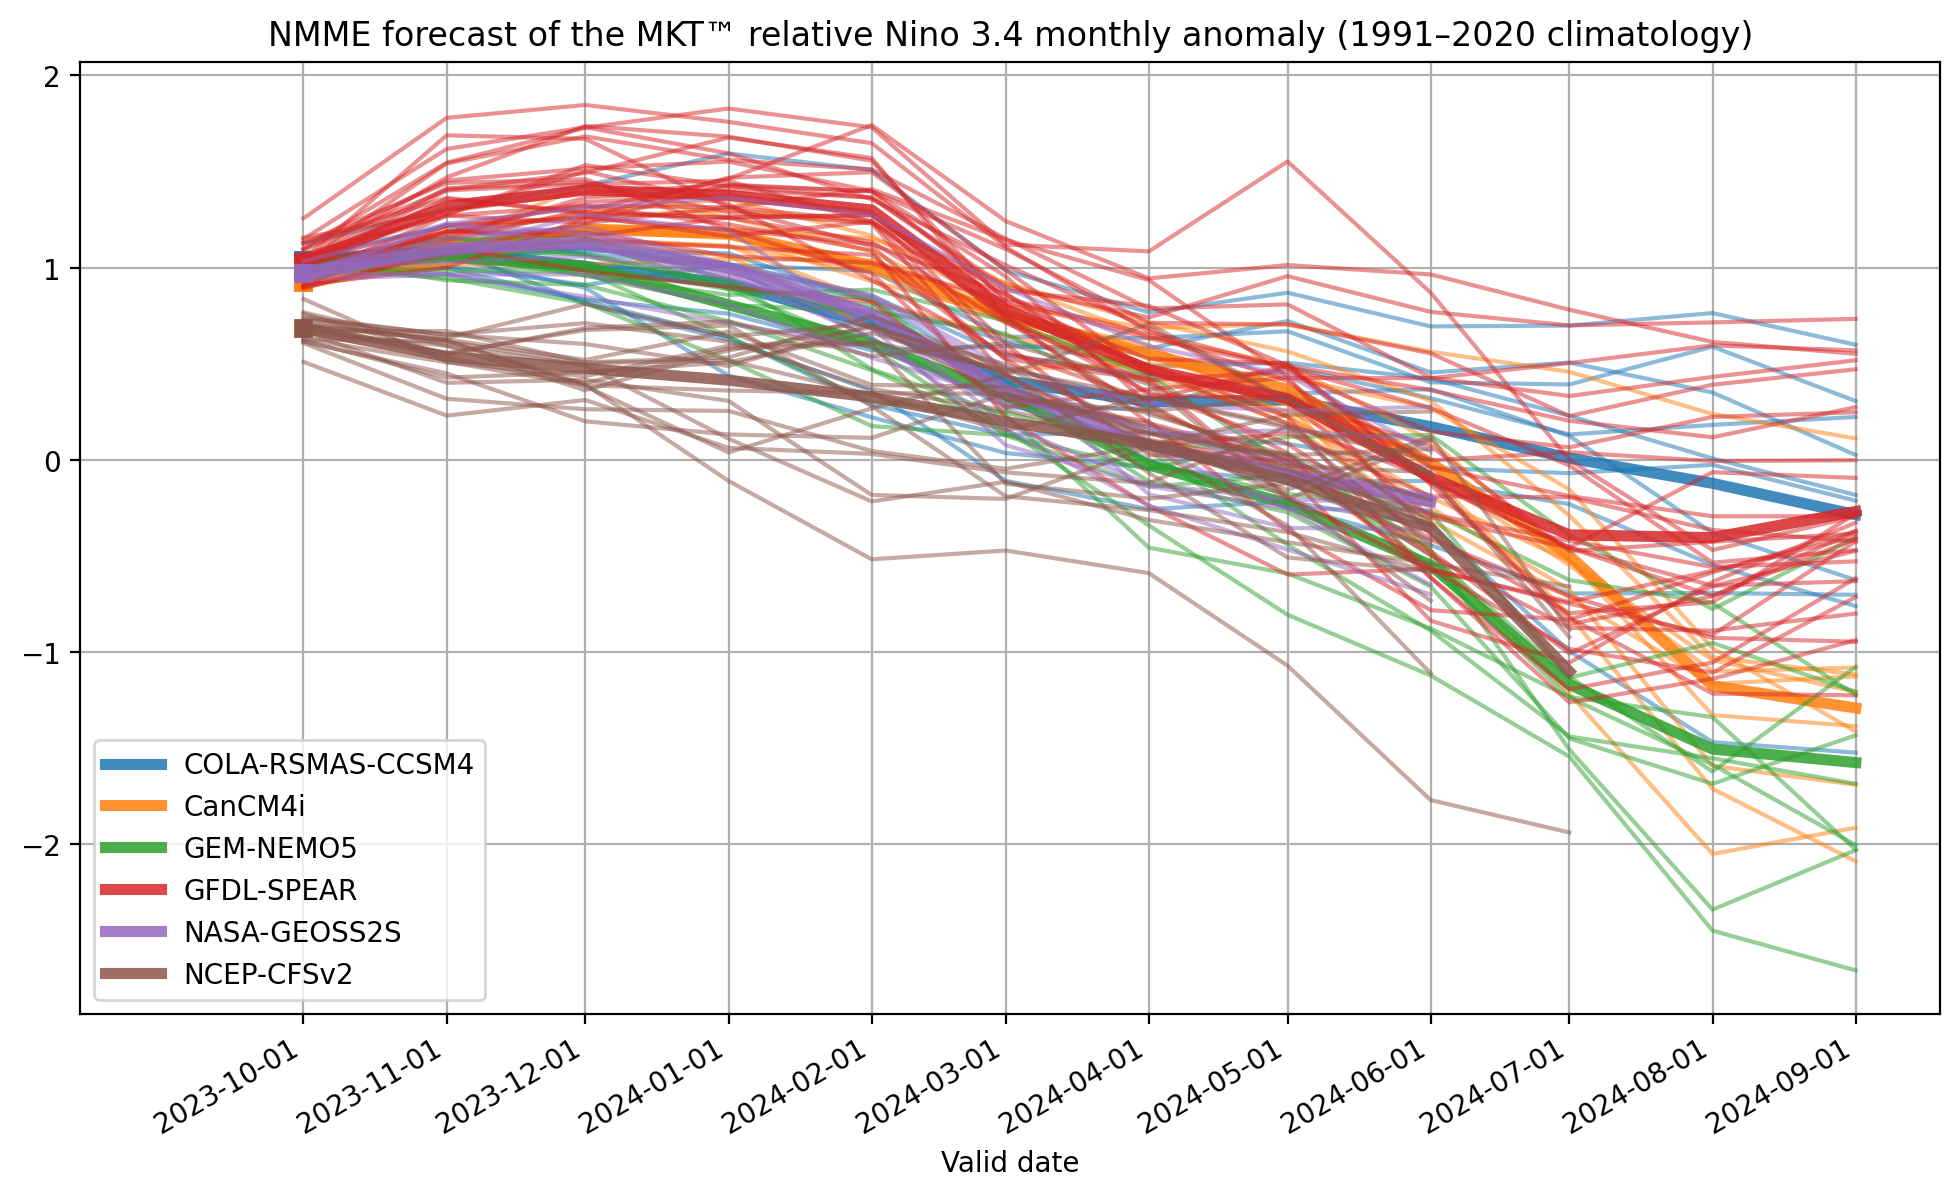

In [61]:
avail = np.where(~np.isnan(ds.ssta.isel(S=-1).isel(L=0).mean('M')))

fig, ax = plt.subplots(figsize=(12, 7))
for im in avail[0]:
    
    #this month
    leads = pd.date_range(start[-1], periods=12, freq="MS")
    ax.plot(leads, ds.ssta.isel(S=-1).isel(model=im).T, lw=1.5, color=colors[im], alpha=0.5)
    ax.plot(leads, ds.ssta.isel(S=-1).mean('M').T[:, im], lw=4, color=colors[im], label=ds.model.values[im], alpha=0.85)
    ax.plot(leads[0], ds.ssta.isel(S=-1).mean('M').T[0, im], 's', lw=3, color=colors[im])

ax.set_xticks(pd.date_range(start[-1], periods=12, freq="MS"))
fig.autofmt_xdate()
ax.legend(ncol=1)
ax.grid()
ax.set_xlabel('Valid date')
ax.set_title('NMME forecast of the MKT™ relative Nino 3.4 monthly anomaly (1991–2020 climatology)')
ax.set_xlim(xlim)
ylim = ax.get_ylim()
fig.set_facecolor("white")
plt.savefig('ens.png')

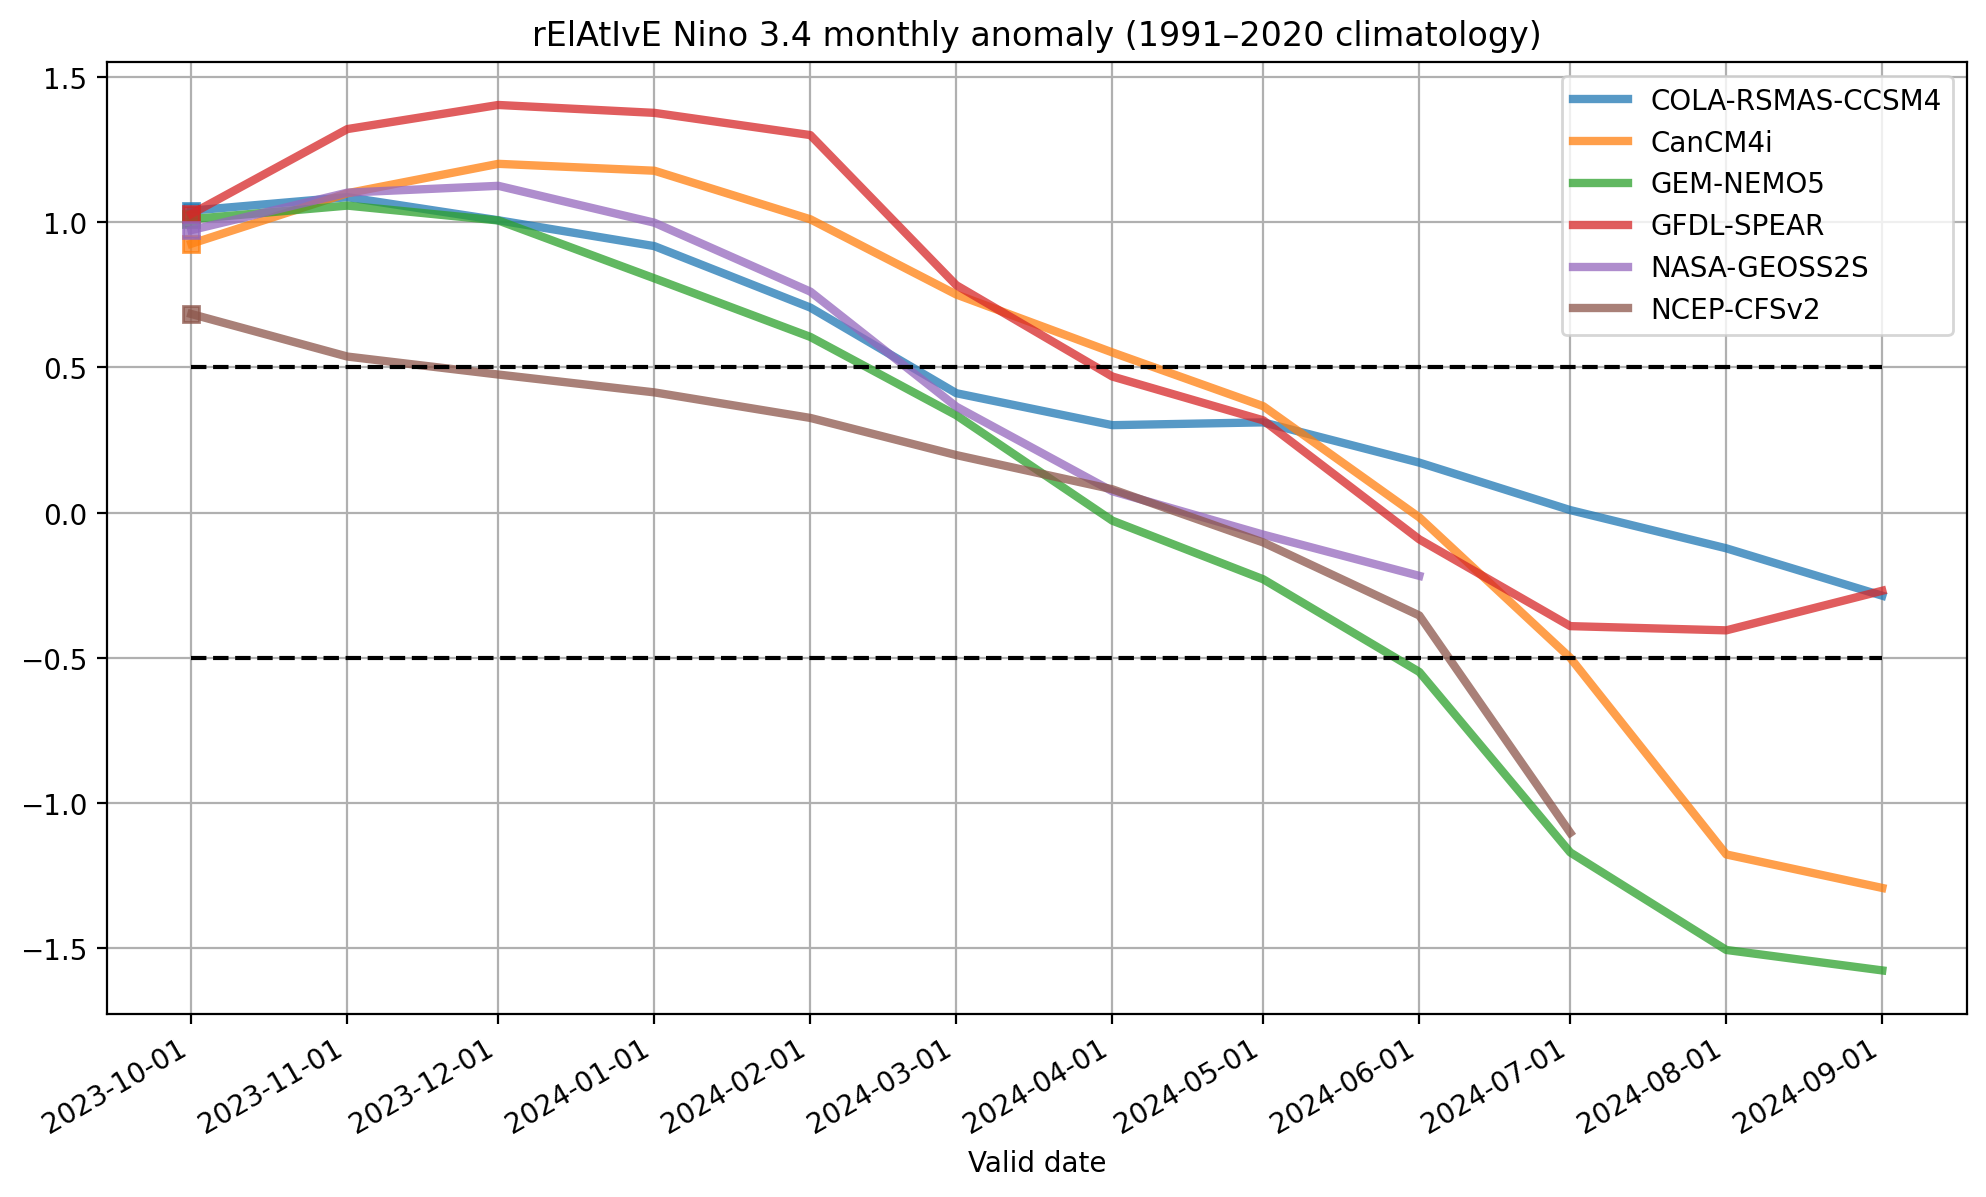

In [62]:
avail = np.where(~np.isnan(ds.ssta.isel(S=-1).isel(L=0).mean('M')))

fig,ax = plt.subplots(figsize=(12, 7))
for im in avail[0]:

    #this month
    leads = pd.date_range(start[-1], periods=12, freq="MS")
    ax.plot(leads, ds.ssta.isel(S=-1).mean('M').T[:, im], lw=3, color=colors[im], label=ds.model.values[im], alpha=0.75)
    ax.plot(leads[0], ds.ssta.isel(S=-1).mean('M').T[0, im], 's', lw=3, color=colors[im], alpha=0.75)

ax.set_xticks(pd.date_range(start[-1], periods=13, freq="MS"))
ax.set_xlabel('Valid date')
ax.set_title('rElAtIvE Nino 3.4 monthly anomaly (1991–2020 climatology)')
ax.plot(leads, np.zeros((12, 2)) + [-0.5, 0.5], 'k--')
fig.autofmt_xdate()

ax.legend(ncol=1)
ax.grid()
fig.set_facecolor("white")
xlim = ax.get_xlim()

plt.savefig('recent.png')